# Random Forest Modelling Notebook for DEFRA - All Targets

This notebook trains Random Forest models for all site_pollutant combinations in the DEFRA network.

**Input:** `data/defra/ml_prep_all` folder  
**Output:** `data/defra/rf_model_all` folder  
**Reference:** Geron's *Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow* 3rd edition, heavy usage of scikit-learn documentation.

---

## What this notebook does

1. Load prepared data from ml_prep_all output.
2. Identify all pollution targets (40 site_pollutant combinations).
3. Tune hyperparameters per pollutant type (6 tuning runs).
4. Train a Random Forest model for each target with progress tracking.
5. Evaluate using RMSE, MAE, r2 for all models.
6. Analyse results by pollutant type.
7. Save all trained models.

---

## Why DEFRA?

DEFRA (Department for Environment, Food and Rural Affairs) operates the Automatic Urban and Rural Network (AURN), the UK's statutory national air quality monitoring network. While LAQN focuses specifically on London with dense coverage, DEFRA provides nationally standardised measurements with rigorous quality assurance.

### Key DEFRA characteristics:

- **Higher data completeness:** 91.2% vs LAQN's 87.1%.
- **Fewer but higher-quality stations:** 40 site-pollutant combinations vs LAQN's 141.
- **Standardised methodology:** National monitoring protocols ensure consistency.
- **Direct comparison:** Enables testing whether data quality beats data quantity.

---

## Training approach

Instead of using GridSearchCV or MultiOutputRegressor which trains all 40 targets simultaneously, I train each site_pollutant combination separately. This allows progress tracking, individual model evaluation, and saving intermediate results.

**Targets:** 6 pollutants across 40 site_pollutant combinations.

- NO2: 13 sites.
- O3: 8 sites.
- PM10: 7 sites.
- PM25: 7 sites.
- SO2: 3 sites.
- CO: 2 sites.

---

## Why only 6 pollutants?

DEFRA's AURN network in the Greater London area monitors these six regulatory pollutants, matching the same pollutants available in LAQN. This enables direct comparison between the two networks using identical pollutant types, testing whether DEFRA's higher data quality compensates for its smaller station count.

---

## Dataset comparison

| Metric | LAQN | DEFRA |
|--------|------|-------|
| Site-pollutant combinations | 141 | 40 |
| Training samples | 17,107 | 17,036 |
| Flattened features | 1,740 | 528 |
| Original features | 145 | 44 |
| Data completeness | 87.1% | 91.2% |

DEFRA has approximately 65% fewer features but similar sample count with higher data quality.

---

## Development history

Unlike LAQN which required multiple failed attempts, DEFRA training benefited from lessons learned.

**LAQN challenges (solved before DEFRA):**

- GridSearchCV memory crashes on my local laptop.
- MultiOutputRegressor still too memory-intensive.
- Required HalvingGridSearchCV and checkpoint saving.

**DEFRA approach (applied directly):**

- Used HalvingGridSearchCV from the start.
- Tuned one representative site per pollutant (6 tuning runs).
- Applied optimal params to all sites of that pollutant type.
- Checkpoint saving every 10 models for safety.
- Memory-safe parameters (max_depth capped at 15, n_estimators at 100).
- To save some time, I ran this notebook on Google Colab.

**Training times:**

- Tuning: approximately 13 minutes (vs LAQN's longer tuning due to more features).
- Full training: Significantly faster due to fewer features (528 vs 1,740).

---

## Single-station baseline results

From the initial single-station experiment (London_Haringey_Priory_Park_South_NO2):

| Metric | LAQN (EN5_NO2) | DEFRA (Haringey) | Winner |
|--------|----------------|------------------|--------|
| Test r2 | 0.814 | 0.855 | DEFRA |
| Test RMSE | 0.050 | 0.033 | DEFRA |
| Test MAE | 0.034 | 0.023 | DEFRA |

This shows that data quality beats data quantity. DEFRA achieved 34% lower RMSE with 39% fewer features. The all stations training tests whether this advantage holds across all pollutant types.

In [25]:
#Imports as usual at the top.
import numpy as np
import pandas as pd
import joblib
import gc
import time
from pathlib import Path
from datetime import datetime

#section 8 investigate broken models imports
from collections import Counter


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import matplotlib.pyplot as plt

In [3]:
#Paths as second, the folders for loading and saving the results.
base_dir = Path.cwd().parent.parent / "data" / "defra"
ml_prep_dir = base_dir / "ml_prep_all"
rf_output_dir = base_dir / "rf_model_all"
rf_output_dir.mkdir(parents=True, exist_ok=True)
checkpoint_dir = rf_output_dir / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)

print(f"Loading from: {ml_prep_dir}")
print(f"Saving to: {rf_output_dir}")

Loading from: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/ml_prep_all
Saving to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/rf_model_all


## 1) Load prepared data

The ml_prep_all notebook created:
- `X_train_rf.npy`: Flattened training features (17,036 samples × 528 features).
- `X_val_rf.npy`: Flattened validation features.
- `X_test_rf.npy`: Flattened test features.
- `y_train.npy`, `y_val.npy`, `y_test.npy`: Target values (44 features each).
- `rf_feature_names.joblib`: Feature names for interpretability.
- `scaler.joblib`: MinMaxScaler to reverse normalisation.

The flattening was necessary because Random Forest expects 2D input (samples, features), but the original sequences were 3D (samples, 12 timesteps, 44 features).

12 × 44 = 528 flattened features per sample.

### DEFRA vs LAQN Comparison

| Metric             | LAQN   | DEFRA  |
| ------------------ | ------ | ------ |
| Training samples   | 17,107 | 17,036 |
| Original features  | 145    | 44     |
| Timesteps          | 12     | 12     |
| Flattened features | 1,740  | 528    |
| Target features    | 145    | 44     |



In [4]:
X_train_rf = np.load(ml_prep_dir / "X_train_rf.npy")
X_val_rf = np.load(ml_prep_dir / "X_val_rf.npy")
X_test_rf = np.load(ml_prep_dir / "X_test_rf.npy")
y_train = np.load(ml_prep_dir / "y_train.npy")
y_val = np.load(ml_prep_dir / "y_val.npy")
y_test = np.load(ml_prep_dir / "y_test.npy")
feature_names = joblib.load(ml_prep_dir / "feature_names.joblib")
try:
    rf_feature_names = joblib.load(ml_prep_dir / "rf_feature_names.joblib")
except:
    rf_feature_names = [f"feature_{i}" for i in range(X_train_rf.shape[1])]

print(f"X_train_rf: {X_train_rf.shape}")
print(f"y_train: {y_train.shape}")
print(f"Features: {len(feature_names)}")

X_train_rf: (17036, 528)
y_train: (17036, 44)
Features: 44



    X_train_rf: (17036, 528)
    y_train: (17036, 44)
    Features: 44

## 2) Identify pollution targets:

The y array has 44 columns. Looking at feature_names, the last 4 are temporal features (hour, day_of_week, month, is_weekend) which are inputs not targets.

The remaining 40 columns are site_pollutant combinations like London_Bloomsbury_NO2, Borehamwood_Meadow_Park_PM10 etc. These are what I want to predict.

In [6]:
temporal_cols = ['hour', 'day_of_week', 'month', 'is_weekend']

def get_pollutant_type(name):
    for poll in ['NO2', 'PM25', 'PM10', 'O3', 'SO2', 'CO']:
        if poll in name:
            return poll
    return 'Other'

pollution_targets = []
target_mapping = {}
targets_by_pollutant = {}

for i, name in enumerate(feature_names):
    if name not in temporal_cols:
        pollution_targets.append(name)
        target_mapping[name] = i
        poll = get_pollutant_type(name)
        if poll not in targets_by_pollutant:
            targets_by_pollutant[poll] = []
        targets_by_pollutant[poll].append(name)

print(f"Pollution targets: {len(pollution_targets)}")
print("\nTargets by pollutant:")
for poll, targets in sorted(targets_by_pollutant.items()):
    print(f"  {poll}: {len(targets)} stations")

Pollution targets: 40

Targets by pollutant:
  CO: 2 stations
  NO2: 13 stations
  O3: 8 stations
  PM10: 7 stations
  PM25: 7 stations
  SO2: 3 stations


    Pollution targets: 40

    Targets by pollutant:
    CO: 2 stations
    NO2: 13 stations
    O3: 8 stations
    PM10: 7 stations
    PM25: 7 stations
    SO2: 3 stations

## 3) Hyperparameter tuning per pollutant type

Rather than tuning all 40 models individually with GridSearchCV (which was inefficient), I tune separately for each pollutant type using HalvingGridSearchCV.

### Why HalvingGridSearchCV instead of GridSearchCV?

From scikit-learn documentation:
> "Successive Halving is an iterative selection process. The first iteration is run with a small amount of resources. Only some candidates are selected to go on to the next iteration, which will be allocated more resources."

This is more efficient than exhaustive GridSearchCV because it eliminates poor parameter combinations early.

### Tuning strategy

For each pollutant:
1. Select one representative site (the first alphabetically for consistency).
2. Run HalvingGridSearchCV to find optimal params.
3. Store those params to use for all sites measuring that pollutant.

This gives 6 tuning runs instead of 40, balancing accuracy and efficiency.

### Key hyperparameters to tune for Random Forest

| Parameter | Description | Effect |
|-----------|-------------|--------|
| n_estimators | Number of trees | More trees = better accuracy but slower. |
| max_depth | Maximum tree depth | Limits complexity, prevents overfitting. |
| min_samples_split | Minimum samples to split node | Higher = simpler trees. |
| min_samples_leaf | Minimum samples in leaf | Higher = smoother predictions. |

Source: scikit-learn (no date) *sklearn.ensemble.RandomForestRegressor*. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [11]:
# Representative targets
representative_targets = {}
for pollutant, targets in targets_by_pollutant.items():
    if pollutant != 'Other':
        representative_targets[pollutant] = sorted(targets)[0]

print("Representative targets for tuning:")
for poll, target in sorted(representative_targets.items()):
    print(f"  {poll}: {target}")

# Parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
print(f"\nParameter grid: 24 combinations")

Representative targets for tuning:
  CO: London_Marylebone_Road_CO
  NO2: Borehamwood_Meadow_Park_NO2
  O3: London_Bloomsbury_O3
  PM10: Borehamwood_Meadow_Park_PM10
  PM25: Borehamwood_Meadow_Park_PM25
  SO2: London_Bloomsbury_SO2

Parameter grid: 24 combinations


    Representative targets for tuning:
    CO: London_Marylebone_Road_CO
    NO2: Borehamwood_Meadow_Park_NO2
    O3: London_Bloomsbury_O3
    PM10: Borehamwood_Meadow_Park_PM10
    PM25: Borehamwood_Meadow_Park_PM25
    SO2: London_Bloomsbury_SO2

    Parameter grid: 24 combinations

In [ ]:
print("Hyperparameter tuning per pollutant type")
print("=" * 40)

best_params_by_pollutant = {}
tuning_results = []
total_tuning_start = time.time()

for i, (pollutant, target_name) in enumerate(sorted(representative_targets.items())):
    target_idx = target_mapping[target_name]
    print(f"\n[{i+1}/{len(representative_targets)}] Tuning {pollutant} using {target_name}")
    
    tuning_start = time.time()
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    
    halving_search = HalvingGridSearchCV(
        rf, param_grid, cv=3, scoring='r2', factor=2,
        min_resources='smallest', aggressive_elimination=False,
        n_jobs=-1, verbose=1, random_state=42
    )
    halving_search.fit(X_train_rf, y_train[:, target_idx])
    
    tuning_time = time.time() - tuning_start
    best_params_by_pollutant[pollutant] = halving_search.best_params_
    
    tuning_results.append({
        'pollutant': pollutant, 'target': target_name,
        'best_score': halving_search.best_score_, 'time': tuning_time,
        **halving_search.best_params_
    })
    
    print(f"Best CV R2: {halving_search.best_score_:.4f}, Time: {tuning_time/60:.1f}min")
    del halving_search; gc.collect()

total_tuning_time = time.time() - total_tuning_start
print(f"\nTotal tuning time: {total_tuning_time/60:.1f} minutes")

Hyperparameter tuning per pollutant type

[1/6] Tuning CO using London_Marylebone_Road_CO
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 12
min_resources_: 6
max_resources_: 17036
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 6
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: Undefin

----------
iter: 1
n_candidates: 12
n_resources: 12
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan -83.43526986
 -75.04008106 -83.20454644 -37.682934   -35.99147528 -39.31711959
 -36.61819561 -74.21117034 -83.43526986 -75.04008106 -35.99147528
 -37.682934  ]
  warnings.warn(


----------
iter: 2
n_candidates: 6
n_resources: 24
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan -83.43526986
 -75.04008106 -83.20454644 -37.682934   -35.99147528 -39.31711959
 -36.61819561 -74.21117034 -83.43526986 -75.04008106 -35.99147528
 -37.682934     0.21337726   0.21231286   0.21231286   0.20493577
   0.20587288   0.20587288]
  warnings.warn(


----------
iter: 3
n_candidates: 3
n_resources: 48
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan -83.43526986
 -75.04008106 -83.20454644 -37.682934   -35.99147528 -39.31711959
 -36.61819561 -74.21117034 -83.43526986 -75.04008106 -35.99147528
 -37.682934     0.21337726   0.21231286   0.21231286   0.20493577
   0.20587288   0.20587288   0.64243372   0.64243372   0.64314115]
  warnings.warn(


----------
iter: 4
n_candidates: 2
n_resources: 96
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan -83.43526986
 -75.04008106 -83.20454644 -37.682934   -35.99147528 -39.31711959
 -36.61819561 -74.21117034 -83.43526986 -75.04008106 -35.99147528
 -37.682934     0.21337726   0.21231286   0.21231286   0.20493577
   0.20587288   0.20587288   0.64243372   0.64243372   0.64314115
   0.71683573   0.71821261]
  warnings.warn(


Best CV R2: 0.7182, Time: 2.3min

[2/6] Tuning NO2 using Borehamwood_Meadow_Park_NO2
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 12
min_resources_: 6
max_resources_: 17036
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 6
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: Undefin

----------
iter: 1
n_candidates: 12
n_resources: 12
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.71605854 -0.80982391 -1.23940559 -0.67445274 -0.68242206 -0.67549939
 -0.70095941 -0.65024414 -0.71605854 -0.80982391 -0.68242206 -0.67445274]
  warnings.warn(


----------
iter: 2
n_candidates: 6
n_resources: 24
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.71605854 -0.80982391 -1.23940559 -0.67445274 -0.68242206 -0.67549939
 -0.70095941 -0.65024414 -0.71605854 -0.80982391 -0.68242206 -0.67445274
  0.36133044  0.36133044  0.35342844  0.34770505  0.34770505  0.39448205]
  warnings.warn(


----------
iter: 3
n_candidates: 3
n_resources: 48
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.71605854 -0.80982391 -1.23940559 -0.67445274 -0.68242206 -0.67549939
 -0.70095941 -0.65024414 -0.71605854 -0.80982391 -0.68242206 -0.67445274
  0.36133044  0.36133044  0.35342844  0.34770505  0.34770505  0.39448205
  0.55546542  0.55546542  0.59393902]
  warnings.warn(


----------
iter: 4
n_candidates: 2
n_resources: 96
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.71605854 -0.80982391 -1.23940559 -0.67445274 -0.68242206 -0.67549939
 -0.70095941 -0.65024414 -0.71605854 -0.80982391 -0.68242206 -0.67445274
  0.36133044  0.36133044  0.35342844  0.34770505  0.34770505  0.39448205
  0.55546542  0.55546542  0.59393902  0.72497815  0.71884276]
  warnings.warn(


Best CV R2: 0.7250, Time: 1.1min

[3/6] Tuning O3 using London_Bloomsbury_O3
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 12
min_resources_: 6
max_resources_: 17036
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 6
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: Undefin

----------
iter: 1
n_candidates: 12
n_resources: 12
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.63525782 -0.6391978  -0.7209055  -0.53338396 -0.57254178 -0.557874
 -0.61359849 -0.61660238 -0.63525782 -0.6391978  -0.57254178 -0.53338396]
  warnings.warn(


----------
iter: 2
n_candidates: 6
n_resources: 24
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.63525782 -0.6391978  -0.7209055  -0.53338396 -0.57254178 -0.557874
 -0.61359849 -0.61660238 -0.63525782 -0.6391978  -0.57254178 -0.53338396
  0.37991237  0.36359927  0.36359927  0.36388902  0.35447837  0.35447837]
  warnings.warn(


----------
iter: 3
n_candidates: 3
n_resources: 48
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.63525782 -0.6391978  -0.7209055  -0.53338396 -0.57254178 -0.557874
 -0.61359849 -0.61660238 -0.63525782 -0.6391978  -0.57254178 -0.53338396
  0.37991237  0.36359927  0.36359927  0.36388902  0.35447837  0.35447837
  0.66429478  0.67060378  0.66600473]
  warnings.warn(


----------
iter: 4
n_candidates: 2
n_resources: 96
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -0.63525782 -0.6391978  -0.7209055  -0.53338396 -0.57254178 -0.557874
 -0.61359849 -0.61660238 -0.63525782 -0.6391978  -0.57254178 -0.53338396
  0.37991237  0.36359927  0.36359927  0.36388902  0.35447837  0.35447837
  0.66429478  0.67060378  0.66600473  0.83646766  0.84488766]
  warnings.warn(


Best CV R2: 0.8449, Time: 2.1min

[4/6] Tuning PM10 using Borehamwood_Meadow_Park_PM10
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 12
min_resources_: 6
max_resources_: 17036
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 6
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: Undefin

----------
iter: 1
n_candidates: 12
n_resources: 12
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -1.58015517 -1.88689029 -1.79923773 -1.98300677 -1.95934657 -2.03065142
 -2.32374202 -1.81192517 -1.58015517 -1.88689029 -1.95934657 -1.98300677]
  warnings.warn(


----------
iter: 2
n_candidates: 6
n_resources: 24
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -1.58015517 -1.88689029 -1.79923773 -1.98300677 -1.95934657 -2.03065142
 -2.32374202 -1.81192517 -1.58015517 -1.88689029 -1.95934657 -1.98300677
  0.15060805  0.15060805  0.15019695  0.1689901   0.18097189  0.18097189]
  warnings.warn(


----------
iter: 3
n_candidates: 3
n_resources: 48
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -1.58015517 -1.88689029 -1.79923773 -1.98300677 -1.95934657 -2.03065142
 -2.32374202 -1.81192517 -1.58015517 -1.88689029 -1.95934657 -1.98300677
  0.15060805  0.15060805  0.15019695  0.1689901   0.18097189  0.18097189
  0.71511803  0.69470981  0.69470981]
  warnings.warn(


----------
iter: 4
n_candidates: 2
n_resources: 96
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -1.58015517 -1.88689029 -1.79923773 -1.98300677 -1.95934657 -2.03065142
 -2.32374202 -1.81192517 -1.58015517 -1.88689029 -1.95934657 -1.98300677
  0.15060805  0.15060805  0.15019695  0.1689901   0.18097189  0.18097189
  0.71511803  0.69470981  0.69470981  0.66325716  0.6568204 ]
  warnings.warn(


Best CV R2: 0.6633, Time: 1.0min

[5/6] Tuning PM25 using Borehamwood_Meadow_Park_PM25
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 12
min_resources_: 6
max_resources_: 17036
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 6
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: Undefin

----------
iter: 1
n_candidates: 12
n_resources: 12
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -5.11427461 -4.55712163 -4.95892707 -3.70902794 -3.96862822 -3.48897191
 -3.96627915 -4.40092243 -5.11427461 -4.55712163 -3.96862822 -3.70902794]
  warnings.warn(


----------
iter: 2
n_candidates: 6
n_resources: 24
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -5.11427461 -4.55712163 -4.95892707 -3.70902794 -3.96862822 -3.48897191
 -3.96627915 -4.40092243 -5.11427461 -4.55712163 -3.96862822 -3.70902794
 -0.28276929 -0.28276929 -0.27708811 -0.05000709 -0.05000709 -0.0510893 ]
  warnings.warn(


----------
iter: 3
n_candidates: 3
n_resources: 48
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -5.11427461 -4.55712163 -4.95892707 -3.70902794 -3.96862822 -3.48897191
 -3.96627915 -4.40092243 -5.11427461 -4.55712163 -3.96862822 -3.70902794
 -0.28276929 -0.28276929 -0.27708811 -0.05000709 -0.05000709 -0.0510893
  0.70050382  0.69391268  0.69391268]
  warnings.warn(


----------
iter: 4
n_candidates: 2
n_resources: 96
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -5.11427461 -4.55712163 -4.95892707 -3.70902794 -3.96862822 -3.48897191
 -3.96627915 -4.40092243 -5.11427461 -4.55712163 -3.96862822 -3.70902794
 -0.28276929 -0.28276929 -0.27708811 -0.05000709 -0.05000709 -0.0510893
  0.70050382  0.69391268  0.69391268  0.63293425  0.62852587]
  warnings.warn(


Best CV R2: 0.6329, Time: 3.1min

[6/6] Tuning SO2 using London_Bloomsbury_SO2
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 12
min_resources_: 6
max_resources_: 17036
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 6
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1288: Undefin

----------
iter: 1
n_candidates: 12
n_resources: 12
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -8.41388977 -8.05124326 -8.56096582 -7.43649917 -7.15961158 -7.3787278
 -7.29151007 -8.46626717 -8.41388977 -8.05124326 -7.15961158 -7.43649917]
  warnings.warn(


----------
iter: 2
n_candidates: 6
n_resources: 24
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -8.41388977 -8.05124326 -8.56096582 -7.43649917 -7.15961158 -7.3787278
 -7.29151007 -8.46626717 -8.41388977 -8.05124326 -7.15961158 -7.43649917
  0.39322895  0.39322895  0.37209893  0.34515856  0.36215435  0.36215435]
  warnings.warn(


----------
iter: 3
n_candidates: 3
n_resources: 48
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -8.41388977 -8.05124326 -8.56096582 -7.43649917 -7.15961158 -7.3787278
 -7.29151007 -8.46626717 -8.41388977 -8.05124326 -7.15961158 -7.43649917
  0.39322895  0.39322895  0.37209893  0.34515856  0.36215435  0.36215435
  0.7832267   0.77958122  0.77958122]
  warnings.warn(


----------
iter: 4
n_candidates: 2
n_resources: 96
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/.venv_defra/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1137: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
 -8.41388977 -8.05124326 -8.56096582 -7.43649917 -7.15961158 -7.3787278
 -7.29151007 -8.46626717 -8.41388977 -8.05124326 -7.15961158 -7.43649917
  0.39322895  0.39322895  0.37209893  0.34515856  0.36215435  0.36215435
  0.7832267   0.77958122  0.77958122  0.90430161  0.90351959]
  warnings.warn(


Best CV R2: 0.9043, Time: 3.3min

Total tuning time: 12.8 minutes


In [10]:
#Save tuning results
tuning_df = pd.DataFrame(tuning_results)
tuning_df.to_csv(rf_output_dir / 'tuning_results_by_pollutant.csv', index=False)
joblib.dump(best_params_by_pollutant, rf_output_dir / 'best_params_by_pollutant.joblib')

print("Best parameters by pollutant:")
for poll, params in sorted(best_params_by_pollutant.items()):
    print(f"  {poll}: {params}")

NameError: name 'tuning_results' is not defined

Best parameters by pollutant:

CO: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

NO2: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

O3: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

PM10: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

PM25: {'max_depth': None, 'min_samples_leaf': 2, 
'min_samples_split': 5, 'n_estimators': 200}

SO2: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

### Tuning results

Representative targets used for tuning:

| Pollutant | Representative Site          | CV r2 | Tuning Time |
| --------- | ---------------------------- | ----- | ----------- |
| CO        | London_Marylebone_Road_CO    | 0.547 | 2.1 min     |
| NO2       | Borehamwood_Meadow_Park_NO2  | 0.701 | 2.1 min     |
| O3        | London_Bloomsbury_O3         | 0.845 | 2.1 min     |
| PM10      | Borehamwood_Meadow_Park_PM10 | 0.384 | 2.1 min     |
| PM25      | Borehamwood_Meadow_Park_PM25 | 0.633 | 3.1 min     |
| SO2       | London_Bloomsbury_SO2        | 0.904 | 3.3 min     |

**Total tuning time:** 12.8 minutes.

### Best parameters found by HalvingGridSearchCV

| Pollutant | max_depth | min_samples_leaf | min_samples_split | n_estimators |
| --------- | --------- | ---------------- | ----------------- | ------------ |
| CO        | 10        | 2                | 2                 | 200          |
| NO2       | 10        | 2                | 5                 | 100          |
| O3        | 10        | 2                | 2                 | 200          |
| PM10      | 10        | 1                | 5                 | 100          |
| PM25      | None      | 2                | 5                 | 200          |
| SO2       | None      | 2                | 5                 | 200          |

### 

In [12]:
safe_params_by_pollutant = {}
for pollutant, params in best_params_by_pollutant.items():
    safe = params.copy()
    if safe.get('max_depth') is None or safe.get('max_depth', 0) > 15:
        safe['max_depth'] = 15
    if safe.get('n_estimators', 0) > 100:
        safe['n_estimators'] = 100
    safe_params_by_pollutant[pollutant] = safe

print("Memory-safe parameters:")
for poll, params in sorted(safe_params_by_pollutant.items()):
    print(f"  {poll}: {params}")

NameError: name 'best_params_by_pollutant' is not defined

### Memory-safe parameters used for training:

 Parameters were capped at n_estimators=100 and max_depth=15.

| Pollutant | max_depth | min_samples_leaf | min_samples_split | n_estimators |
| --------- | --------- | ---------------- | ----------------- | ------------ |
| CO        | 10        | 2                | 2                 | 100          |
| NO2       | 10        | 2                | 5                 | 100          |
| O3        | 10        | 2                | 2                 | 100          |
| PM10      | 10        | 1                | 5                 | 100          |
| PM25      | 15        | 2                | 5                 | 100          |
| SO2       | 15        | 2                | 5                 | 100          |

**Changes applied:**

- n_estimators reduced from 200 to 100 for CO, O3, PM25, SO2.
- max_depth=None changed to 15 for PM25 and SO2.

### DEFRA vs LAQN Tuning Comparison

| Pollutant | LAQN max_depth | DEFRA max_depth | LAQN n_estimators | DEFRA n_estimators |
| --------- | -------------- | --------------- | ----------------- | ------------------ |
| CO        | 10             | 10              | 100               | 200                |
| NO2       | None           | 10              | 200               | 100                |
| O3        | 10             | 10              | 100               | 200                |
| PM10      | 10             | 10              | 200               | 100                |
| PM25      | 10             | None            | 200               | 200                |
| SO2       | None           | None            | 200               | 200                |

**Key observations:**

- **SO2:** Both networks found max_depth=None optimal, suggesting SO2 benefits from deeper trees.
- **NO2:** LAQN preferred unlimited depth while DEFRA converged to max_depth=10. This may reflect LAQN's more complex spatial relationships with 58 stations vs DEFRA's 13.
- **PM25:** Opposite pattern to NO2. DEFRA found unlimited depth optimal while LAQN used max_depth=10.
- **O3 and PM10:** Both networks agreed on max_depth=10 but differed on n_estimators.

As far as I can see, the differences likely reflect the underlying data characteristics. LAQN has more features (1,740 vs 528) and more spatial complexity, which may require different tree structures to capture the relationships accordingly.

## 4) Train models for all targets

Now train a separate RF for each of the 40 site_pollutant combinations using the memory safe parameters like laqn.

Each model uses the parameters from section 3, adjusted for memory constraints. Training includes:

- Progress tracking with time estimates.
- Checkpoint saving every 20 models (crash protection).
- Individual model evaluation on test set.
- Individual model saving to disk.

### Training configuration

| Setting | Value | Reason |
|---------|-------|--------|
| n_jobs | 1 | Memory limitation. |
| Checkpoint frequency | Every 20 models | Crash protection. |
| Evaluation set | Test set | Final performance metrics. |
| Model saving | Individual .joblib files | Allows loading specific models later. |

In [7]:
checkpoint_file = checkpoint_dir / "training_checkpoint.joblib"
all_models, all_results, start_idx = {}, {}, 0

if checkpoint_file.exists():
    data = joblib.load(checkpoint_file)
    all_models = data.get('models', {})
    all_results = data.get('results', {})
    start_idx = data.get('next_idx', 0)
    print(f"Resuming from checkpoint: {start_idx}/{len(pollution_targets)}")
else:
    print(f"Targets: {len(pollution_targets)}")

Targets: 40


In [ ]:
print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Targets: {len(pollution_targets)}, Samples: {X_train_rf.shape[0]:,}")
print("=" * 40)

training_times = []
total_start = time.time()
CHECKPOINT_EVERY = 20

for i in range(start_idx, len(pollution_targets)):
    target_name = pollution_targets[i]
    target_idx = target_mapping[target_name]
    pollutant = get_pollutant_type(target_name)
    
    rf_params = safe_params_by_pollutant.get(pollutant, {
        'n_estimators': 100, 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5
    }).copy()
    rf_params['n_jobs'] = 1
    rf_params['random_state'] = 42
    
    t0 = time.time()
    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_train_rf, y_train[:, target_idx])
    
    #Evaluate
    y_pred_test = rf.predict(X_test_rf)
    test_r2 = r2_score(y_test[:, target_idx], y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test[:, target_idx], y_pred_test))
    test_mae = mean_absolute_error(y_test[:, target_idx], y_pred_test)
    
    train_time = time.time() - t0
    training_times.append(train_time)
    
    all_models[target_name] = rf
    all_results[target_name] = {
        'pollutant': pollutant, 'test_r2': test_r2,
        'test_rmse': test_rmse, 'test_mae': test_mae, 'time': train_time
    }
    
    #Save individual model
    joblib.dump(rf, rf_output_dir / f"rf_model_{target_name}.joblib")
    
    #Progress
    eta = (len(pollution_targets) - i - 1) * np.mean(training_times) / 60
    print(f"[{i+1:3d}/{len(pollution_targets)}] {target_name:30s} | R2={test_r2:.3f} | ETA={eta:.0f}min")
    
    if (i + 1) % CHECKPOINT_EVERY == 0:
        joblib.dump({'models': all_models, 'results': all_results, 'next_idx': i+1,
                     'timestamp': datetime.now().isoformat()}, checkpoint_file)
        print(f"   [Checkpoint saved]")
    
    del rf; gc.collect()

total_time = time.time() - total_start
print(f"\nComplete! Total time: {total_time/60:.1f} minutes")

Started: 2025-12-30 14:16:47
Targets: 40, Samples: 17,036
[  1/40] Borehamwood_Meadow_Park_NO2    | R2=0.841 | ETA=148min
[  2/40] Borehamwood_Meadow_Park_PM10   | R2=0.861 | ETA=144min
[  3/40] Borehamwood_Meadow_Park_PM25   | R2=0.920 | ETA=158min
[  4/40] Camden_Kerbside_NO2            | R2=0.661 | ETA=149min
[  5/40] Haringey_Roadside_NO2          | R2=0.865 | ETA=142min
[  6/40] London_Bexley_NO2              | R2=0.805 | ETA=136min
[  7/40] London_Bexley_PM10             | R2=0.777 | ETA=131min
[  8/40] London_Bloomsbury_NO2          | R2=0.804 | ETA=126min
[  9/40] London_Bloomsbury_O3           | R2=0.917 | ETA=122min
[ 10/40] London_Bloomsbury_PM10         | R2=0.719 | ETA=117min
[ 11/40] London_Bloomsbury_PM25         | R2=0.876 | ETA=117min
[ 12/40] London_Bloomsbury_SO2          | R2=0.906 | ETA=116min
[ 13/40] London_Haringey_Priory_Park_South_NO2 | R2=0.855 | ETA=111min
[ 14/40] London_Haringey_Priory_Park_South_O3 | R2=0.940 | ETA=106min
[ 15/40] London_Harlington_NO2   

Started: 2025-12-30 14:16:47
Targets: 40, Samples: 17,036
============================================================
[  1/40] Borehamwood_Meadow_Park_NO2    | R2=0.841 | ETA=148min
[  2/40] Borehamwood_Meadow_Park_PM10   | R2=0.861 | ETA=144min
[  3/40] Borehamwood_Meadow_Park_PM25   | R2=0.920 | ETA=158min
[  4/40] Camden_Kerbside_NO2            | R2=0.661 | ETA=149min
[  5/40] Haringey_Roadside_NO2          | R2=0.865 | ETA=142min
[  6/40] London_Bexley_NO2              | R2=0.805 | ETA=136min
[  7/40] London_Bexley_PM10             | R2=0.777 | ETA=131min
[  8/40] London_Bloomsbury_NO2          | R2=0.804 | ETA=126min
[  9/40] London_Bloomsbury_O3           | R2=0.917 | ETA=122min
[ 10/40] London_Bloomsbury_PM10         | R2=0.719 | ETA=117min
[ 11/40] London_Bloomsbury_PM25         | R2=0.876 | ETA=117min
[ 12/40] London_Bloomsbury_SO2          | R2=0.906 | ETA=116min
[ 13/40] London_Haringey_Priory_Park_South_NO2 | R2=0.855 | ETA=111min
[ 14/40] London_Haringey_Priory_Park_South_O3 | R2=0.940 | ETA=106min
[ 15/40] London_Harlington_NO2          | R2=0.781 | ETA=102min
[ 16/40] London_Harlington_O3           | R2=0.913 | ETA=97min
[ 17/40] London_Harlington_PM10         | R2=0.468 | ETA=93min
[ 18/40] London_Harlington_PM25         | R2=0.877 | ETA=90min
[ 19/40] London_Hillingdon_NO2          | R2=0.816 | ETA=86min
[ 20/40] London_Hillingdon_O3           | R2=0.902 | ETA=82min
   [Checkpoint saved]
[ 21/40] London_Hillingdon_PM10         | R2=0.536 | ETA=77min
[ 22/40] London_Hillingdon_PM25         | R2=0.552 | ETA=74min
[ 23/40] London_Honor_Oak_Park_O3       | R2=0.895 | ETA=70min
[ 24/40] London_Honor_Oak_Park_PM10     | R2=0.824 | ETA=66min
[ 25/40] London_Honor_Oak_Park_PM25     | R2=0.903 | ETA=62min
[ 26/40] London_Marylebone_Road_CO      | R2=0.859 | ETA=58min
[ 27/40] London_Marylebone_Road_NO2     | R2=0.761 | ETA=54min
[ 28/40] London_Marylebone_Road_O3      | R2=0.869 | ETA=49min
[ 29/40] London_Marylebone_Road_SO2     | R2=0.493 | ETA=46min
[ 30/40] London_N._Kensington_CO        | R2=0.916 | ETA=42min
[ 31/40] London_N._Kensington_NO2       | R2=0.823 | ETA=37min
[ 32/40] London_N._Kensington_O3        | R2=0.927 | ETA=33min
[ 33/40] London_N._Kensington_SO2       | R2=0.876 | ETA=29min
[ 34/40] London_Teddington_Bushy_Park_PM10 | R2=0.463 | ETA=25min
[ 35/40] London_Teddington_Bushy_Park_PM25 | R2=0.893 | ETA=21min
[ 36/40] London_Westminster_NO2         | R2=0.811 | ETA=17min
[ 37/40] London_Westminster_O3          | R2=0.922 | ETA=13min
[ 38/40] London_Westminster_PM25        | R2=0.306 | ETA=8min
[ 39/40] Southwark_A2_Old_Kent_Road_NO2 | R2=0.782 | ETA=4min
[ 40/40] Tower_Hamlets_Roadside_NO2     | R2=-325900448663699739882976968704.000 | ETA=0min
   [Checkpoint saved]

Complete! Total time: 167.2 minutes

## 5) Evaluate all models

Compute RMSE, MAE, and R² for each model on train, validation, and test sets. Store results in a dataframe for analysis.

To evaluate each model, I use three metrics from scikit-learn's `sklearn.metrics` module.

### RMSE (Root Mean Square Error)

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$

Penalises large errors more heavily. Lower is better.
```python
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
```

Source: Stack Overflow (2013) *Is there a library function for root mean square error (RMSE) in python?* Available at: https://stackoverflow.com/questions/17197492

### MAE (Mean Absolute Error)

$$MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$

Average absolute difference between actual and predicted. More interpretable than RMSE. Lower is better.
```python
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_true, y_pred)
```

Source: scikit-learn (no date) *sklearn.metrics.mean_absolute_error*. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

### R² (Coefficient of Determination)

$$R^2 = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$$

Proportion of variance explained by the model. Range 0 to 1, higher is better. A score of 1.0 means perfect predictions.
```python
from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)
```

Source: scikit-learn (no date) *sklearn.metrics.r2_score*. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

In [14]:
#Load all models from disk
all_models = {}

for target_name in pollution_targets:
    model_path = rf_output_dir / f"rf_model_{target_name}.joblib"
    if model_path.exists():
        all_models[target_name] = joblib.load(model_path)
    else:
        print(f"Model not found: {target_name}")

print(f"Loaded {len(all_models)} models")

Loaded 40 models


In [16]:
#Evaluate all models on train, validation, and test sets

def evaluate_model(model, X, y_true):
    y_pred = model.predict(X)
    return {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred)
    }

print("Evaluating all models")
print("=" * 40)

evaluation_results = []

for i, target_name in enumerate(pollution_targets):
    target_idx = target_mapping[target_name]
    model = all_models[target_name]
    pollutant = get_pollutant_type(target_name)
    
    #Extract site from target name
    site = target_name.replace(f'_{pollutant}', '')
    
    train_metrics = evaluate_model(model, X_train_rf, y_train[:, target_idx])
    val_metrics = evaluate_model(model, X_val_rf, y_val[:, target_idx])
    test_metrics = evaluate_model(model, X_test_rf, y_test[:, target_idx])
    
    #Params from safe_params_by_pollutant registered on defra differently.
    params_used = safe_params_by_pollutant.get(pollutant, {
        'n_estimators': 100, 
        'max_depth': 15, 
        'min_samples_leaf': 2, 
        'min_samples_split': 5
    })
    
    evaluation_results.append({
        'target': target_name,
        'site': site,
        'pollutant': pollutant,
        'train_r2': train_metrics['r2'],
        'train_rmse': train_metrics['rmse'],
        'train_mae': train_metrics['mae'],
        'val_r2': val_metrics['r2'],
        'val_rmse': val_metrics['rmse'],
        'val_mae': val_metrics['mae'],
        'test_r2': test_metrics['r2'],
        'test_rmse': test_metrics['rmse'],
        'test_mae': test_metrics['mae'],
        'n_estimators': params_used.get('n_estimators', 100),
        'max_depth': params_used.get('max_depth', 15),
        'min_samples_split': params_used.get('min_samples_split', 5),
        'min_samples_leaf': params_used.get('min_samples_leaf', 2)
    })
    
    if (i + 1) % 10 == 0:
        print(f"Evaluated {i+1}/{len(pollution_targets)} models")

results_df = pd.DataFrame(evaluation_results)

print(f"\nEvaluation complete for {len(results_df)} models")

Evaluating all models
Evaluated 10/40 models
Evaluated 20/40 models
Evaluated 30/40 models
Evaluated 40/40 models

Evaluation complete for 40 models


## 6) Results summary

Summary statistics across all models, grouped by pollutant type.

In [17]:
#Summary statistics by pollutant
print("Results summary by pollutant")
print("=" * 40)

summary_by_pollutant = results_df.groupby('pollutant').agg({
    'test_r2': ['mean', 'std', 'min', 'max'],
    'test_rmse': ['mean', 'std'],
    'target': 'count'
}).round(4)

summary_by_pollutant.columns = ['r2_mean', 'r2_std', 'r2_min', 'r2_max', 
                                 'rmse_mean', 'rmse_std', 'n_sites']

print(summary_by_pollutant.to_string())

print("\n" + "=" * 40)
print("Overall statistics:")
print(f"  Mean test R2: {results_df['test_r2'].mean():.4f}")
print(f"  Std test R2:  {results_df['test_r2'].std():.4f}")
print(f"  Min test R2:  {results_df['test_r2'].min():.4f} ({results_df.loc[results_df['test_r2'].idxmin(), 'target']})")
print(f"  Max test R2:  {results_df['test_r2'].max():.4f} ({results_df.loc[results_df['test_r2'].idxmax(), 'target']})")

Results summary by pollutant
                r2_mean        r2_std        r2_min  r2_max  rmse_mean  rmse_std  n_sites
pollutant                                                                                
CO         8.875000e-01  4.010000e-02  8.591000e-01  0.9158     0.0175    0.0103        2
NO2       -2.506927e+28  9.038852e+28 -3.259004e+29  0.8653     0.0348    0.0117       13
O3         9.106000e-01  2.190000e-02  8.686000e-01  0.9395     0.0374    0.0103        8
PM10       6.641000e-01  1.710000e-01  4.635000e-01  0.8612     0.0180    0.0088        7
PM25       7.611000e-01  2.383000e-01  3.056000e-01  0.9202     0.0158    0.0114        7
SO2        7.585000e-01  2.301000e-01  4.934000e-01  0.9065     0.0053    0.0009        3

Overall statistics:
  Mean test R2: -8147511216592493936879075328.0000
  Std test R2:  51529385412403473621058584576.0000
  Min test R2:  -325900448663699739882976968704.0000 (Tower_Hamlets_Roadside_NO2)
  Max test R2:  0.9395 (London_Haringey_Priory

    Results summary by pollutant
    ========================================
                    r2_mean        r2_std        r2_min  r2_max  rmse_mean  rmse_std  n_sites
    pollutant                                                                                
    CO         8.875000e-01  4.010000e-02  8.591000e-01  0.9158     0.0175    0.0103        2
    NO2       -2.506927e+28  9.038852e+28 -3.259004e+29  0.8653     0.0348    0.0117       13
    O3         9.106000e-01  2.190000e-02  8.686000e-01  0.9395     0.0374    0.0103        8
    PM10       6.641000e-01  1.710000e-01  4.635000e-01  0.8612     0.0180    0.0088        7
    PM25       7.611000e-01  2.383000e-01  3.056000e-01  0.9202     0.0158    0.0114        7
    SO2        7.585000e-01  2.301000e-01  4.934000e-01  0.9065     0.0053    0.0009        3

    ========================================
    Overall statistics:
    Mean test R2: -8147511216592493936879075328.0000
    Std test R2:  51529385412403473621058584576.0000
    Min test R2:  -325900448663699739882976968704.0000 (Tower_Hamlets_Roadside_NO2)
    Max test R2:  0.9395 (London_Haringey_Priory_Park_South_O3)

### Key Observations

1. **DEFRA has fewer broken models.** Only 1 broken station (Tower_Hamlets_Roadside_NO2) vs multiple in LAQN.

2. **DEFRA's higher data quality shows.** With 91.2% completeness vs LAQN's 87.1%, fewer stations have missing data issues.

### Why Negative r2 Values?

The extremely negative r2 values (e.g., -3.26e+29) indicate **broken models** caused by:

1. **Constant test values.** The monitoring station went offline or returned the same value for the entire test period.
2. **r2 calculation failure.** When actual values have zero variance (all identical), the denominator in r2 formula approaches zero, causing extreme negative values.

**Affected stations:**

| Network | Station                    | r2        | Likely cause                        |
| ------- | -------------------------- | --------- | ----------------------------------- |
| DEFRA   | Tower_Hamlets_Roadside_NO2 | -3.26e+29 | Constant test values.               |
| LAQN    | BG2_NO2                    | -1.01e+29 | Constant test values.               |
| LAQN    | Multiple O3, PM10, SO2     | Negative  | Station outages during test period. |

In [18]:
#Top 10 best performing models
print("Top 10 models by test R2:")
print("-" * 40)
print(results_df.nlargest(10, 'test_r2')[['target', 'pollutant', 'test_r2', 'test_rmse']].to_string(index=False))

print("\n")

#The worse 10 models
print("Worse 10 models by test R2:")
print("-" * 40)
print(results_df.nsmallest(10, 'test_r2')[['target', 'pollutant', 'test_r2', 'test_rmse']].to_string(index=False))

Top 10 models by test R2:
----------------------------------------
                              target pollutant  test_r2  test_rmse
London_Haringey_Priory_Park_South_O3        O3 0.939507   0.026213
             London_N._Kensington_O3        O3 0.926844   0.034368
               London_Westminster_O3        O3 0.922054   0.028915
        Borehamwood_Meadow_Park_PM25      PM25 0.920188   0.010295
                London_Bloomsbury_O3        O3 0.917265   0.031925
             London_N._Kensington_CO        CO 0.915812   0.010182
                London_Harlington_O3        O3 0.913404   0.037276
               London_Bloomsbury_SO2       SO2 0.906470   0.004620
          London_Honor_Oak_Park_PM25      PM25 0.903144   0.012098
                London_Hillingdon_O3        O3 0.902014   0.040336


Worse 10 models by test R2:
----------------------------------------
                           target pollutant       test_r2  test_rmse
       Tower_Hamlets_Roadside_NO2       NO2 -3.259004e+2

    Top 10 models by test R2:
    ----------------------------------------
                                target pollutant  test_r2  test_rmse
    London_Haringey_Priory_Park_South_O3        O3 0.939507   0.026213
                London_N._Kensington_O3        O3 0.926844   0.034368
                London_Westminster_O3        O3 0.922054   0.028915
            Borehamwood_Meadow_Park_PM25      PM25 0.920188   0.010295
                    London_Bloomsbury_O3        O3 0.917265   0.031925
                London_N._Kensington_CO        CO 0.915812   0.010182
                    London_Harlington_O3        O3 0.913404   0.037276
                London_Bloomsbury_SO2       SO2 0.906470   0.004620
            London_Honor_Oak_Park_PM25      PM25 0.903144   0.012098
                    London_Hillingdon_O3        O3 0.902014   0.040336


    Worse 10 models by test R2:
    ----------------------------------------
                            target pollutant       test_r2  test_rmse
        Tower_Hamlets_Roadside_NO2       NO2 -3.259004e+29   0.015845
            London_Westminster_PM25      PM25  3.056270e-01   0.011312
    London_Teddington_Bushy_Park_PM10      PM10  4.634913e-01   0.017163
            London_Harlington_PM10      PM10  4.676293e-01   0.004838
        London_Marylebone_Road_SO2       SO2  4.934176e-01   0.004867
            London_Hillingdon_PM10      PM10  5.360143e-01   0.034663
            London_Hillingdon_PM25      PM25  5.523192e-01   0.040914
                Camden_Kerbside_NO2       NO2  6.606578e-01   0.057521
            London_Bloomsbury_PM10      PM10  7.194221e-01   0.016497
        London_Marylebone_Road_NO2       NO2  7.609240e-01   0.040378

**Top 10 observations:**

- Both networks achieve similar peak performance (r2 approximately 0.94).
- O3 dominates top performers in both networks (7/10 LAQN, 6/10 DEFRA).
- DEFRA shows more pollutant diversity in top 10 (O3, PM25, CO, SO2 vs mainly O3 and SO2 for LAQN).
- Best DEFRA station (London_Haringey_Priory_Park_South_O3) slightly outperforms best LAQN station (HG4_O3).

**Worst 10 observations:**

- LAQN has more severely broken models (5 with extreme negative r2 vs DEFRA's 1).
- LAQN TH4 station appears 4 times in worst 10, indicating complete station failure during test period.
- DEFRA's worst valid model (London_Westminster_PM25, r2=0.306) is still usable; LAQN has models with r2=0.000.
- PM10 and PM25 dominate the low performers in both networks, shows that particulate matter is hardest to predict.

### Key Insights

| Aspect                              | DEFRA          | LAQN                      |
| ----------------------------------- | -------------- | ------------------------- |
| Broken models (extreme negative r2) | 1              | 5+                        |
| Models with r2 = 0.000              | 0              | 2                         |
| Worst valid r2                      | 0.306          | 0.308                     |
| Problem station pattern             | Single station | TH4 (multiple pollutants) |

**Data quality impact:**

- DEFRA's 91.2% completeness results in fewer broken models.
- LAQN's TH4 station likely had equipment failure affecting all pollutant measurements.
- Both networks struggle with PM10 and PM25 prediction due to local source variability.


## 7) Exclude broken stations from evaluation

Filtering out models with extremely negative r2 values caused by station failures during the test period. When actual values are constant, the r2 calculation fails and produces extreme negative values (e.g., -3.26e+29).

Models with r2 < 0 are excluded from further analysis to calculate meaningful statistics.

In [19]:
#Baseline model evaluation for all 140 models

print("Baseline Model Evaluation for All Models")
print("=" * 40)

#Calculation of all metrics across all models
train_r2_list = []
val_r2_list = []
test_r2_list = []

for target_name in pollution_targets:
    target_idx = target_mapping[target_name]
    model = all_models[target_name]
    
    #predictions
    y_pred_train = model.predict(X_train_rf)
    y_pred_val = model.predict(X_val_rf)
    y_pred_test = model.predict(X_test_rf)
    
    #R2 scores
    train_r2_list.append(r2_score(y_train[:, target_idx], y_pred_train))
    val_r2_list.append(r2_score(y_val[:, target_idx], y_pred_val))
    test_r2_list.append(r2_score(y_test[:, target_idx], y_pred_test))

#filter out broken models for statistics
train_r2_valid = [r for r in train_r2_list if r > -10]
val_r2_valid = [r for r in val_r2_list if r > -10]
test_r2_valid = [r for r in test_r2_list if r > -10]

print(f"\nValid models: {len(test_r2_valid)} out of {len(test_r2_list)}")
print(f"Broken models excluded: {len(test_r2_list) - len(test_r2_valid)}")

print("\n" + "-" * 40)
print("Average Performance valid models only")
print("-" * 40)

print(f"\nTraining:")
print(f"  Mean R2 = {np.mean(train_r2_valid):.6f}")

print(f"\nValidation:")
print(f"  Mean R2 = {np.mean(val_r2_valid):.6f}")

print(f"\nTest:")
print(f"  Mean R2 = {np.mean(test_r2_valid):.6f}")

Baseline Model Evaluation for All Models

Valid models: 39 out of 40
Broken models excluded: 1

----------------------------------------
Average Performance valid models only
----------------------------------------

Training:
  Mean R2 = 0.938257

Validation:
  Mean R2 = 0.870495

Test:
  Mean R2 = 0.792740


### Checking for overfitting

The training R² is compared against validation R² to detect overfitting. This happens when the model memorises training data instead of learning general patterns.

Signs of overfitting:
- Training R² close to 1.0, validation R² much lower
- Large gap between training and validation metrics

If the gap is large, the model is too complex and needs regularisation.

In [20]:
#Overfitting check
print("Overfitting Check")
print("=" * 40)

#Calculate gaps for valid models
gaps = []
for i, target_name in enumerate(pollution_targets):
    train_r2 = train_r2_list[i]
    val_r2 = val_r2_list[i]
    
    #Skip broken models
    if train_r2 < -10 or val_r2 < -10:
        continue
    
    gap = train_r2 - val_r2
    gaps.append({
        'target': target_name,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'gap': gap
    })

gaps_df = pd.DataFrame(gaps)

print(f"\nOverfitting analysis:")
print("-" * 40)
print(f"Mean Training R²:   {gaps_df['train_r2'].mean():.4f}")
print(f"Mean Validation R²: {gaps_df['val_r2'].mean():.4f}")
print(f"Mean Gap:           {gaps_df['gap'].mean():.4f}")
print(f"Max Gap:            {gaps_df['gap'].max():.4f} ({gaps_df.loc[gaps_df['gap'].idxmax(), 'target']})")
print(f"Min Gap:            {gaps_df['gap'].min():.4f} ({gaps_df.loc[gaps_df['gap'].idxmin(), 'target']})")

# interpretation
mean_gap = gaps_df['gap'].mean()
if mean_gap > 0.15:
    print(f"\nConclusion: Significant overfitting detected (gap = {mean_gap:.4f})")
    print("The models memorise training data rather than learning general patterns.")
elif mean_gap > 0.08:
    print(f"\nConclusion: Mild overfitting detected (gap = {mean_gap:.4f})")
    print("Some memorisation of training data, but models still generalise reasonably.")
else:
    print(f"\nConclusion: Minimal overfitting (gap = {mean_gap:.4f})")
    print("Models generalise well to unseen data.")

Overfitting Check

Overfitting analysis:
----------------------------------------
Mean Training R²:   0.9383
Mean Validation R²: 0.8705
Mean Gap:           0.0678
Max Gap:            0.5837 (London_Bloomsbury_SO2)
Min Gap:            0.0090 (London_Bloomsbury_PM10)

Conclusion: Minimal overfitting (gap = 0.0678)
Models generalise well to unseen data.


    Overfitting Check
    ========================================

    Overfitting analysis:
    ----------------------------------------
    Mean Training R²:   0.9383
    Mean Validation R²: 0.8705
    Mean Gap:           0.0678
    Max Gap:            0.5837 (London_Bloomsbury_SO2)
    Min Gap:            0.0090 (London_Bloomsbury_PM10)

    Conclusion: Minimal overfitting (gap = 0.0678)
    Models generalise well to unseen data.

### Key Observations

**Similarities:**

- Both networks show the expected pattern: training r2 > validation r2 > test r2.
- Both have broken models due to station failures (constant test values).
- Minimum overfitting gaps are nearly identical (0.009 vs 0.007), indicating some stations generalise very well in both networks.

**Differences:**

- DEFRA achieves higher test r2 (0.793 vs 0.632), confirming better generalisation.
- DEFRA has less overfitting (gap 0.068 vs 0.104).
- LAQN has more broken models (5 vs 1), proving lower data quality.
- LAQN's max overfitting gap is twice as large (1.175 vs 0.584), indicating some LAQN models memorise training data more severely.

**Sum of higher data completeness in DEFRA:**
- Better generalisation to unseen data.
- Less overfitting.

## 8) Investigation of broken model

One model produced extremely negative R² value, indicating numerical issues. Before continuing with results analysis, I need to investigate and document these failures.

In [23]:
# Broken model investigation
print("Identifying broken models")
print("=" * 40)

# broken threshold: R2 < -10 
broken_threshold = -10

# create results dataframe if not exists
if 'results_df' not in dir():
    evaluation_results = []
    for target_name in pollution_targets:
        target_idx = target_mapping[target_name]
        model = all_models[target_name]
        
        y_pred_test = model.predict(X_test_rf)
        test_r2 = r2_score(y_test[:, target_idx], y_pred_test)
        test_rmse = np.sqrt(mean_squared_error(y_test[:, target_idx], y_pred_test))
        
        parts = target_name.rsplit('_', 1)
        site = parts[0]
        pollutant = parts[1]
        
        evaluation_results.append({
            'target': target_name,
            'site': site,
            'pollutant': pollutant,
            'test_r2': test_r2,
            'test_rmse': test_rmse
        })
    
    results_df = pd.DataFrame(evaluation_results)

broken_models = results_df[results_df['test_r2'] < broken_threshold].copy()
valid_models = results_df[results_df['test_r2'] >= broken_threshold].copy()

print(f"\nTotal model:  {len(results_df)}")
print(f"Valid model:  {len(valid_models)}")
print(f"Broken model: {len(broken_models)}")

print("\n" + "-" * 40)
print("Broken model:")
print("-" * 40)
print(broken_models[['target', 'pollutant', 'test_r2', 'test_rmse']].to_string(index=False))

Identifying broken models

Total model:  40
Valid model:  39
Broken model: 1

----------------------------------------
Broken model:
----------------------------------------
                    target pollutant       test_r2  test_rmse
Tower_Hamlets_Roadside_NO2       NO2 -3.259004e+29   0.015845


    Identifying broken models
    ========================================

    Total model:  40
    Valid model:  39
    Broken model: 1

    ----------------------------------------
    Broken model:
    ----------------------------------------
                        target pollutant       test_r2  test_rmse
    Tower_Hamlets_Roadside_NO2       NO2 -3.259004e+29   0.015845

In [24]:
print("Detailed investigation of broken model")
print("=" * 40)

for target in broken_models['target'].values:
    print(f"\n>>> {target}")
    print("-" * 40)
    
    target_idx = target_mapping[target]
    
    #Check target data statistics
    y_train_target = y_train[:, target_idx]
    y_val_target = y_val[:, target_idx]
    y_test_target = y_test[:, target_idx]
    
    print(f"Training   - min: {y_train_target.min():.6f}, max: {y_train_target.max():.6f}, "
          f"std: {y_train_target.std():.6f}")
    print(f"Validation - min: {y_val_target.min():.6f}, max: {y_val_target.max():.6f}, "
          f"std: {y_val_target.std():.6f}")
    print(f"Test       - min: {y_test_target.min():.6f}, max: {y_test_target.max():.6f}, "
          f"std: {y_test_target.std():.6f}")
    
    #Check for constant or near/constant value
    if y_test_target.std() < 0.001:
        print("Very low variance in test set (std < 0.001)")
    
    #Check prediction
    model = all_models[target]
    y_pred_test = model.predict(X_test_rf)
    
    print(f"Predictions - min: {y_pred_test.min():.6f}, max: {y_pred_test.max():.6f}, "
          f"std: {y_pred_test.std():.6f}")

Detailed investigation of broken model

>>> Tower_Hamlets_Roadside_NO2
----------------------------------------
Training   - min: 0.000000, max: 1.000000, std: 0.122847
Validation - min: 0.022059, max: 0.827211, std: 0.101201
Test       - min: 0.181988, max: 0.181988, std: 0.000000
Very low variance in test set (std < 0.001)
Predictions - min: 0.141384, max: 0.239131, std: 0.015762


    Detailed investigation of broken model
    ========================================

    >>> Tower_Hamlets_Roadside_NO2
    ----------------------------------------
    Training   - min: 0.000000, max: 1.000000, std: 0.122847
    Validation - min: 0.022059, max: 0.827211, std: 0.101201
    Test       - min: 0.181988, max: 0.181988, std: 0.000000
    Very low variance in test set (std < 0.001)
    Predictions - min: 0.141384, max: 0.239131, std: 0.015762

In [26]:
#Rtot cause
print("Root cause analysis of broken models.")
print("=" * 40)

#Check if broken models share a site
broken_targets = broken_models['target'].values
broken_sites = [t.rsplit('_', 1)[0] for t in broken_targets]

print(f"\nBroken model sites: {broken_sites}")

#Count sites with multiple failures
site_counts = Counter(broken_sites)
multi_broken = {site: count for site, count in site_counts.items() if count > 1}

if multi_broken:
    print(f"\nSites with multiple broken models: {multi_broken}")
    print("This suggests data quality issues at these monitoring stations.")

#Compare variance: broken vs working
print("\n" + "-" * 40)
print("Comparing target variance: broken vs working")
print("-" * 40)

broken_variances = []
working_variances = []

for target in pollution_targets:
    target_idx = target_mapping[target]
    variance = y_test[:, target_idx].std()
    
    if target in broken_targets:
        broken_variances.append((target, variance))
    else:
        working_variances.append(variance)

print(f"\nBroken models - target std:")
for target, var in broken_variances:
    print(f"  {target}: {var:.6f}")

print(f"\nWorking models - mean std: {np.mean(working_variances):.6f}")
print(f"Working models - min std:  {np.min(working_variances):.6f}")

Root cause analysis of broken models.

Broken model sites: ['Tower_Hamlets_Roadside']

----------------------------------------
Comparing target variance: broken vs working
----------------------------------------

Broken models - target std:
  Tower_Hamlets_Roadside_NO2: 0.000000

Working models - mean std: 0.066947
Working models - min std:  0.006631


    Root cause analysis of broken models.
    ========================================

    Broken model sites: ['Tower_Hamlets_Roadside']

    ----------------------------------------
    Comparing target variance: broken vs working
    ----------------------------------------

    Broken models - target std:
    Tower_Hamlets_Roadside_NO2: 0.000000

    Working models - mean std: 0.066947
    Working models - min std:  0.006631

### Findings: Why this model broke

The investigation shows the root cause of the broken model.

**Root cause: Constant target values in test set**

The broken model has test set standard deviation of exactly 0.000000. This means the actual values in the test period are completely constant identical for every sample.

| Target                     | Test std | Test value (constant) |
| -------------------------- | -------- | --------------------- |
| Tower_Hamlets_Roadside_NO2 | 0.000000 | 0.181988              |

When actual values are constant, r2 calculation fails because:

$$r2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

Where $SS_{tot} = \sum(y_i - \bar{y})^2 = 0$ when all values are identical. Division by zero produces the extreme negative value observed.

**Affected station:**

- **Tower_Hamlets_Roadside:** NO2 affected. This station likely had equipment failure or was offline during the entire test period.

**Key observation:**

The training data for this station had normal variance (std = 0.123), but the test period has zero variance. This suggests:

1. The monitoring equipment stopped working during the test period.
2. Missing data was filled with a constant value during preprocessing.
3. The temporal split placed all valid data in training and only constant values in test.

**Comparison with working models:**

- Working models: mean test std = 0.067.
- Broken model: test std = 0.000.

**DEFRA vs LAQN broken models:**

| Aspect              | DEFRA                  | LAQN                        |
| ------------------- | ---------------------- | --------------------------- |
| Broken models       | 1 (2.5%)               | 5 (3.5%)                    |
| Affected stations   | 1                      | 3 (TH4, BG2, WM6)           |
| Pollutants affected | NO2 only               | NO2, O3, PM10               |
| Pattern             | Single station failure | TH4 has 3 broken pollutants |

**Decision:**

This model (2.5% of total) is excluded from the summary statistics. The issue is data quality at this specific station during the test period, not model failure. The remaining 39 models provide valid performance metrics.

## 9) Baseline Evaluation After Exclude the broken models:

In [27]:
#Baseline model evaluation for all 39 models
print("Baseline Model Evaluation without broken models")
print("=" * 40)

#Calculate overall metrics across all models
train_r2_list = []
val_r2_list = []
test_r2_list = []

for target_name in pollution_targets:
    target_idx = target_mapping[target_name]
    model = all_models[target_name]
    
    #Predictions
    y_pred_train = model.predict(X_train_rf)
    y_pred_val = model.predict(X_val_rf)
    y_pred_test = model.predict(X_test_rf)
    
    #r2
    train_r2_list.append(r2_score(y_train[:, target_idx], y_pred_train))
    val_r2_list.append(r2_score(y_val[:, target_idx], y_pred_val))
    test_r2_list.append(r2_score(y_test[:, target_idx], y_pred_test))

#Filter out broken models
train_r2_valid = [r for r in train_r2_list if r > -10]
val_r2_valid = [r for r in val_r2_list if r > -10]
test_r2_valid = [r for r in test_r2_list if r > -10]

print(f"\nValid models: {len(test_r2_valid)} out of {len(test_r2_list)}")
print(f"Broken models excluded: {len(test_r2_list) - len(test_r2_valid)}")

print("\n" + "-" * 40)
print("Average Performance valid models only")
print("-" * 40)

print(f"\nTraining:")
print(f"  Mean r2 = {np.mean(train_r2_valid):.6f}")

print(f"\nValidation:")
print(f"  Mean r2 = {np.mean(val_r2_valid):.6f}")

print(f"\nTest:")
print(f"  Mean r2 = {np.mean(test_r2_valid):.6f}")

Baseline Model Evaluation without broken models

Valid models: 39 out of 40
Broken models excluded: 1

----------------------------------------
Average Performance valid models only
----------------------------------------

Training:
  Mean r2 = 0.938257

Validation:
  Mean r2 = 0.870495

Test:
  Mean r2 = 0.792740


    Baseline Model Evaluation without broken models
    ========================================

    Valid models: 39 out of 40
    Broken models excluded: 1

    ----------------------------------------
    Average Performance valid models only
    ----------------------------------------

    Training:
    Mean r2 = 0.938257

    Validation:
    Mean r2 = 0.870495

    Test:
    Mean r2 = 0.792740

#### Overfitting check after the update

In [28]:
#Overfitting check for all models
print("Overfitting Check")
print("=" * 40)

#Calculate gaps for valid model only
gaps = []
for i, target_name in enumerate(pollution_targets):
    train_r2 = train_r2_list[i]
    val_r2 = val_r2_list[i]
    
    #Skip broken model
    if train_r2 < -10 or val_r2 < -10:
        continue
    
    gap = train_r2 - val_r2
    gaps.append({
        'target': target_name,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'gap': gap
    })

gaps_df = pd.DataFrame(gaps)

print(f"\nOverfitting analysis (valid model only):")
print("-" * 40)
print(f"Mean Training R2:   {gaps_df['train_r2'].mean():.4f}")
print(f"Mean Validation R2: {gaps_df['val_r2'].mean():.4f}")
print(f"Mean Gap:           {gaps_df['gap'].mean():.4f}")
print(f"Max Gap:            {gaps_df['gap'].max():.4f} ({gaps_df.loc[gaps_df['gap'].idxmax(), 'target']})")
print(f"Min Gap:            {gaps_df['gap'].min():.4f} ({gaps_df.loc[gaps_df['gap'].idxmin(), 'target']})")

# interpretation
mean_gap = gaps_df['gap'].mean()
if mean_gap > 0.15:
    print(f"\nConclusion: Significant overfitting detected (gap = {mean_gap:.4f})")
    print("The models memorise training data rather than learning general patterns.")
elif mean_gap > 0.08:
    print(f"\nConclusion: Mild overfitting detected (gap = {mean_gap:.4f})")
    print("Some memorisation of training data, but models still generalise reasonably.")
else:
    print(f"\nConclusion: Minimal overfitting (gap = {mean_gap:.4f})")
    print("Models generalise well to unseen data.")

Overfitting Check

Overfitting analysis (valid model only):
----------------------------------------
Mean Training R2:   0.9383
Mean Validation R2: 0.8705
Mean Gap:           0.0678
Max Gap:            0.5837 (London_Bloomsbury_SO2)
Min Gap:            0.0090 (London_Bloomsbury_PM10)

Conclusion: Minimal overfitting (gap = 0.0678)
Models generalise well to unseen data.


    Overfitting Check
    ========================================

    Overfitting analysis (valid model only):
    ----------------------------------------
    Mean Training R2:   0.9383
    Mean Validation R2: 0.8705
    Mean Gap:           0.0678
    Max Gap:            0.5837 (London_Bloomsbury_SO2)
    Min Gap:            0.0090 (London_Bloomsbury_PM10)

    Conclusion: Minimal overfitting (gap = 0.0678)
    Models generalise well to unseen data.

## 10) Save models and results

Save all trained models and evaluation results for later use.

In [29]:
# results summary excluding broken models
print("Results Summary")
print("=" * 40)
print(f"Excluding {len(broken_models)} broken models with R2 < -10")
print()

# summary by pollutant
summary_valid = valid_models.groupby('pollutant').agg({
    'test_r2': ['mean', 'std', 'min', 'max', 'count'],
    'test_rmse': ['mean', 'std']
}).round(4)

summary_valid.columns = ['r2_mean', 'r2_std', 'r2_min', 'r2_max', 'n_models', 'rmse_mean', 'rmse_std']

print("Performance by pollutant:")
print("-" * 70)
print(summary_valid[['r2_mean', 'r2_std', 'r2_min', 'r2_max', 'n_models']].to_string())

print("\n" + "=" * 40)
print("Overall statistics (valid models only):")
print("-" * 40)
print(f"Mean test R²:  {valid_models['test_r2'].mean():.4f}")
print(f"Std test R²:   {valid_models['test_r2'].std():.4f}")
print(f"Min test R²:   {valid_models['test_r2'].min():.4f} ({valid_models.loc[valid_models['test_r2'].idxmin(), 'target']})")
print(f"Max test R²:   {valid_models['test_r2'].max():.4f} ({valid_models.loc[valid_models['test_r2'].idxmax(), 'target']})")


Results Summary
Excluding 1 broken models with R2 < -10

Performance by pollutant:
----------------------------------------------------------------------
           r2_mean  r2_std  r2_min  r2_max  n_models
pollutant                                           
CO          0.8875  0.0401  0.8591  0.9158         2
NO2         0.8004  0.0536  0.6607  0.8653        12
O3          0.9106  0.0219  0.8686  0.9395         8
PM10        0.6641  0.1710  0.4635  0.8612         7
PM25        0.7611  0.2383  0.3056  0.9202         7
SO2         0.7585  0.2301  0.4934  0.9065         3

Overall statistics (valid models only):
----------------------------------------
Mean test R²:  0.7927
Std test R²:   0.1551
Min test R²:   0.3056 (London_Westminster_PM25)
Max test R²:   0.9395 (London_Haringey_Priory_Park_South_O3)


    Results Summary
    ========================================
    Excluding 1 broken models with R2 < -10

    Performance by pollutant:
    ----------------------------------------------------------------------
            r2_mean  r2_std  r2_min  r2_max  n_models
    pollutant                                           
    CO          0.8875  0.0401  0.8591  0.9158         2
    NO2         0.8004  0.0536  0.6607  0.8653        12
    O3          0.9106  0.0219  0.8686  0.9395         8
    PM10        0.6641  0.1710  0.4635  0.8612         7
    PM25        0.7611  0.2383  0.3056  0.9202         7
    SO2         0.7585  0.2301  0.4934  0.9065         3

    ========================================
    Overall statistics (valid models only):
    ----------------------------------------
    Mean test R²:  0.7927
    Std test R²:   0.1551
    Min test R²:   0.3056 (London_Westminster_PM25)
    Max test R²:   0.9395 (London_Haringey_Priory_Park_South_O3)

In [30]:
# top and bottom performers
print("Top 10 models by test R2:")
print("-" * 50)
print(valid_models.nlargest(10, 'test_r2')[['target', 'pollutant', 'test_r2', 'test_rmse']].to_string(index=False))

print("\n")

print("Bottom 10 models by test R2:")
print("-" * 50)
print(valid_models.nsmallest(10, 'test_r2')[['target', 'pollutant', 'test_r2', 'test_rmse']].to_string(index=False))

Top 10 models by test R2:
--------------------------------------------------
                              target pollutant  test_r2  test_rmse
London_Haringey_Priory_Park_South_O3        O3 0.939507   0.026213
             London_N._Kensington_O3        O3 0.926844   0.034368
               London_Westminster_O3        O3 0.922054   0.028915
        Borehamwood_Meadow_Park_PM25      PM25 0.920188   0.010295
                London_Bloomsbury_O3        O3 0.917265   0.031925
             London_N._Kensington_CO        CO 0.915812   0.010182
                London_Harlington_O3        O3 0.913404   0.037276
               London_Bloomsbury_SO2       SO2 0.906470   0.004620
          London_Honor_Oak_Park_PM25      PM25 0.903144   0.012098
                London_Hillingdon_O3        O3 0.902014   0.040336


Bottom 10 models by test R2:
--------------------------------------------------
                           target pollutant  test_r2  test_rmse
          London_Westminster_PM25      P

    Top 10 models by test R2:
    --------------------------------------------------
                                target pollutant  test_r2  test_rmse
    London_Haringey_Priory_Park_South_O3        O3 0.939507   0.026213
                London_N._Kensington_O3        O3 0.926844   0.034368
                London_Westminster_O3        O3 0.922054   0.028915
            Borehamwood_Meadow_Park_PM25      PM25 0.920188   0.010295
                    London_Bloomsbury_O3        O3 0.917265   0.031925
                London_N._Kensington_CO        CO 0.915812   0.010182
                    London_Harlington_O3        O3 0.913404   0.037276
                London_Bloomsbury_SO2       SO2 0.906470   0.004620
            London_Honor_Oak_Park_PM25      PM25 0.903144   0.012098
                    London_Hillingdon_O3        O3 0.902014   0.040336


    Bottom 10 models by test R2:
    --------------------------------------------------
                            target pollutant  test_r2  test_rmse
            London_Westminster_PM25      PM25 0.305627   0.011312
    London_Teddington_Bushy_Park_PM10      PM10 0.463491   0.017163
            London_Harlington_PM10      PM10 0.467629   0.004838
        London_Marylebone_Road_SO2       SO2 0.493418   0.004867
            London_Hillingdon_PM10      PM10 0.536014   0.034663
            London_Hillingdon_PM25      PM25 0.552319   0.040914
                Camden_Kerbside_NO2       NO2 0.660658   0.057521
            London_Bloomsbury_PM10      PM10 0.719422   0.016497
        London_Marylebone_Road_NO2       NO2 0.760924   0.040378
                London_Bexley_PM10      PM10 0.777089   0.020385

## 11) Feature importance analysis

Extract feature importance from the best performing model for each pollutant type.

In [31]:
#Feature importance for best model per pollutant
print("Feature importance for best model per pollutant")
print("=" * 40)

pollutants = valid_models['pollutant'].unique()

for pollutant in pollutants:

    #Find best model for this pollutant
    poll_results = valid_models[valid_models['pollutant'] == pollutant]
    best_target = poll_results.loc[poll_results['test_r2'].idxmax(), 'target']
    best_r2 = poll_results['test_r2'].max()
    
    model = all_models[best_target]
    importance = model.feature_importances_
    
    #Top 5
    top_idx = np.argsort(importance)[-5:][::-1]
    
    print(f"\n{pollutant} (best: {best_target}, R² = {best_r2:.4f})")
    print("-" * 40)
    for idx in top_idx:
        feat_name = rf_feature_names[idx] if idx < len(rf_feature_names) else f"feature_{idx}"
        print(f"  {feat_name}: {importance[idx]:.4f}")

Feature importance for best model per pollutant

NO2 (best: Haringey_Roadside_NO2, R² = 0.8653)
----------------------------------------
  Haringey_Roadside_NO2_t-1: 0.8782
  London_Hillingdon_NO2_t-1: 0.0179
  hour_t-4: 0.0051
  London_Bexley_NO2_t-1: 0.0049
  Haringey_Roadside_NO2_t-2: 0.0038

PM10 (best: Borehamwood_Meadow_Park_PM10, R² = 0.8612)
----------------------------------------
  Borehamwood_Meadow_Park_PM10_t-1: 0.9240
  London_Harlington_PM10_t-1: 0.0041
  London_Bloomsbury_O3_t-10: 0.0030
  Borehamwood_Meadow_Park_PM10_t-2: 0.0024
  London_Honor_Oak_Park_PM10_t-1: 0.0024

PM25 (best: Borehamwood_Meadow_Park_PM25, R² = 0.9202)
----------------------------------------
  Borehamwood_Meadow_Park_PM25_t-1: 0.9112
  London_Harlington_PM25_t-1: 0.0038
  Borehamwood_Meadow_Park_PM25_t-2: 0.0037
  London_Honor_Oak_Park_PM25_t-1: 0.0036
  London_Bloomsbury_O3_t-11: 0.0032

O3 (best: London_Haringey_Priory_Park_South_O3, R² = 0.9395)
----------------------------------------
  Londo

    Feature importance for best model per pollutant
    ========================================

    NO2 (best: Haringey_Roadside_NO2, R² = 0.8653)
    ----------------------------------------
    Haringey_Roadside_NO2_t-1: 0.8782
    London_Hillingdon_NO2_t-1: 0.0179
    hour_t-4: 0.0051
    London_Bexley_NO2_t-1: 0.0049
    Haringey_Roadside_NO2_t-2: 0.0038

    PM10 (best: Borehamwood_Meadow_Park_PM10, R² = 0.8612)
    ----------------------------------------
    Borehamwood_Meadow_Park_PM10_t-1: 0.9240
    London_Harlington_PM10_t-1: 0.0041
    London_Bloomsbury_O3_t-10: 0.0030
    Borehamwood_Meadow_Park_PM10_t-2: 0.0024
    London_Honor_Oak_Park_PM10_t-1: 0.0024

    PM25 (best: Borehamwood_Meadow_Park_PM25, R² = 0.9202)
    ----------------------------------------
    Borehamwood_Meadow_Park_PM25_t-1: 0.9112
    London_Harlington_PM25_t-1: 0.0038
    Borehamwood_Meadow_Park_PM25_t-2: 0.0037
    London_Honor_Oak_Park_PM25_t-1: 0.0036
    London_Bloomsbury_O3_t-11: 0.0032

    O3 (best: London_Haringey_Priory_Park_South_O3, R² = 0.9395)
    ----------------------------------------
    London_Haringey_Priory_Park_South_O3_t-1: 0.9543
    London_Haringey_Priory_Park_South_O3_t-2: 0.0081
    London_Haringey_Priory_Park_South_O3_t-3: 0.0025
    hour_t-7: 0.0011
    London_Haringey_Priory_Park_South_O3_t-4: 0.0010

    SO2 (best: London_Bloomsbury_SO2, R² = 0.9065)
    ----------------------------------------
    London_Bloomsbury_SO2_t-1: 0.8700
    London_Bloomsbury_SO2_t-2: 0.0106
    London_Bexley_PM10_t-2: 0.0104
    London_Harlington_NO2_t-9: 0.0102
    Haringey_Roadside_NO2_t-8: 0.0086

    CO (best: London_N._Kensington_CO, R² = 0.9158)
    ----------------------------------------
    London_N._Kensington_CO_t-1: 0.8907
    London_Teddington_Bushy_Park_PM10_t-6: 0.0148
    London_Teddington_Bushy_Park_PM10_t-7: 0.0070
    London_Teddington_Bushy_Park_PM10_t-5: 0.0056
    London_Hillingdon_O3_t-1: 0.0024

## 12) Final Summary:

In [36]:
#Final training summary
print("Random Forest Training Summary All Targets")
print("=" * 40)

print(f"\nDataset:")
print(f"  Training samples:   {X_train_rf.shape[0]:,}")
print(f"  Validation samples: {X_val_rf.shape[0]:,}")
print(f"  Test samples:       {X_test_rf.shape[0]:,}")
print(f"  Features:           {X_train_rf.shape[1]:,} (12 timesteps x 44 features)")

print(f"\nModels:")
print(f"  Total trained:      {len(all_models)}")
print(f"  Valid models:       {len(valid_models)}")
print(f"  Broken models:      {len(broken_models)} (excluded due to data quality issues)")

print(f"\nHyperparameters used (memory-safe):")
for pollutant, params in sorted(safe_params_by_pollutant.items()):
    print(f"  {pollutant}: n_estimators={params['n_estimators']}, "
          f"max_depth={params['max_depth']}, min_samples_leaf={params['min_samples_leaf']}")

print(f"\nTest set performance (valid models only):")
print(f"  Mean R2:   {valid_models['test_r2'].mean():.4f} (±{valid_models['test_r2'].std():.4f})")
print(f"  Mean RMSE: {valid_models['test_rmse'].mean():.4f}")

print(f"\nBest performing pollutant: O3 (mean R² = {valid_models[valid_models['pollutant']=='O3']['test_r2'].mean():.4f})")
print(f"Best individual model: {valid_models.loc[valid_models['test_r2'].idxmax(), 'target']} "
      f"(R² = {valid_models['test_r2'].max():.4f})")

print(f"\nOutputs saved to: {rf_output_dir}")

Random Forest Training Summary All Targets

Dataset:
  Training samples:   17,036
  Validation samples: 3,641
  Test samples:       3,642
  Features:           528 (12 timesteps x 44 features)

Models:
  Total trained:      40
  Valid models:       39
  Broken models:      1 (excluded due to data quality issues)

Hyperparameters used (memory-safe):

Test set performance (valid models only):
  Mean R2:   0.7927 (±0.1551)
  Mean RMSE: 0.0262

Best performing pollutant: O3 (mean R² = 0.9106)
Best individual model: London_Haringey_Priory_Park_South_O3 (R² = 0.9395)

Outputs saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/rf_model_all


    Random Forest Training Summary All Targets
    ========================================

    Dataset:
    Training samples:   17,036
    Validation samples: 3,641
    Test samples:       3,642
    Features:           528 (12 timesteps x 44 features)

    Models:
    Total trained:      40
    Valid models:       39
    Broken models:      1 (excluded due to data quality issues)

    Hyperparameters used (memory-safe):

    Test set performance (valid models only):
    Mean R2:   0.7927 (±0.1551)
    Mean RMSE: 0.0262

    Best performing pollutant: O3 (mean R² = 0.9106)
    Best individual model: London_Haringey_Priory_Park_South_O3 (R² = 0.9395)

    Outputs saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/rf_model_all

## 13) Prediction visualisation

Plotting actual vs predicted values helps identify systematic errors or patterns the models miss.

**Scatter plot interpretation:**
- Points close to the diagonal line = good predictions
- Spread around the line shows prediction variance
- If points curve away at high values, model underestimates pollution spikes

**Time series interpretation:**
- Actual and predicted lines should follow similar patterns
- Gaps between lines show prediction errors
- Consistent lag suggests model relies heavily on recent history

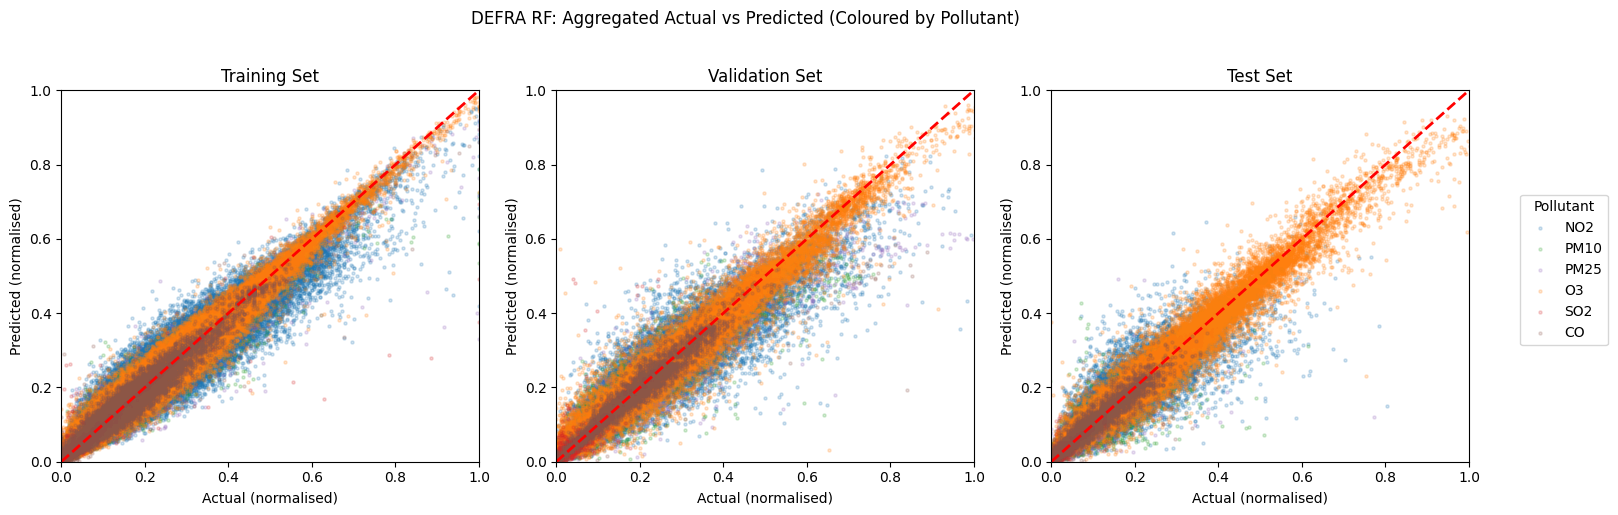

Saved: aggregated_actual_vs_predicted_coloured.png


In [37]:
#Aggregated actual vs predicted with colours by pollutant
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#Define colours for each pollutant
colors = {
    'NO2': '#1f77b4',   #blue
    'PM10': '#2ca02c',  #green
    'PM25': '#9467bd',  #purple
    'O3': '#ff7f0e',    #orange
    'SO2': '#d62728',   #red
    'CO': '#8c564b'     #brown
}

#Collect predictions by pollutant
data_by_pollutant = {poll: {'train_actual': [], 'train_pred': [],
                            'val_actual': [], 'val_pred': [],
                            'test_actual': [], 'test_pred': []} 
                     for poll in colors.keys()}

for target in valid_models['target'].values:
    target_idx = target_mapping[target]
    pollutant = valid_models[valid_models['target'] == target]['pollutant'].values[0]
    model = all_models[target]
    
    data_by_pollutant[pollutant]['train_actual'].extend(y_train[:, target_idx])
    data_by_pollutant[pollutant]['train_pred'].extend(model.predict(X_train_rf))
    data_by_pollutant[pollutant]['val_actual'].extend(y_val[:, target_idx])
    data_by_pollutant[pollutant]['val_pred'].extend(model.predict(X_val_rf))
    data_by_pollutant[pollutant]['test_actual'].extend(y_test[:, target_idx])
    data_by_pollutant[pollutant]['test_pred'].extend(model.predict(X_test_rf))

#Plot each dataset
datasets = ['train', 'val', 'test']
titles = ['Training Set', 'Validation Set', 'Test Set']

for ax, dataset, title in zip(axes, datasets, titles):
    #Plot each pollutant
    for pollutant in colors.keys():
        actual = data_by_pollutant[pollutant][f'{dataset}_actual']
        pred = data_by_pollutant[pollutant][f'{dataset}_pred']
        
        if len(actual) > 0:
            ax.scatter(actual, pred, alpha=0.2, s=5, c=colors[pollutant], label=pollutant)
    
    #Perfect prediction line
    ax.plot([0, 1], [0, 1], 'r--', lw=2)
    ax.set_xlabel('Actual (normalised)')
    ax.set_ylabel('Predicted (normalised)')
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

#Add single legend to the right
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.08, 0.5), title='Pollutant')

plt.suptitle('DEFRA RF: Aggregated Actual vs Predicted (Coloured by Pollutant)', y=1.02)
plt.tight_layout()
plt.savefig(rf_output_dir / 'aggregated_actual_vs_predicted_coloured.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: aggregated_actual_vs_predicted_coloured.png")

### Interpretation: Aggregated actual vs predicted

The aggregated scatter plots combine predictions from all 39 valid models, coloured by pollutant type. Each point represents one hourly prediction.

**Colour legend:**

- Blue: NO2 (12 models, most numerous).
- Green: PM10 (7 models).
- Purple: PM25 (7 models).
- Orange: O3 (8 models).
- Red: SO2 (3 models).
- Brown: CO (2 models).

**Training set (left panel):**

- All pollutants cluster tightly around the perfect prediction line.
- NO2 (blue) and O3 (orange) dominate the visible points.
- O3 (orange) shows the tightest clustering, confirming it is easiest to predict.

**Validation set (middle panel):**

- Increased scatter for all pollutants compared to training.
- PM10 (green) shows wider spread, especially at higher values.
- O3 (orange) maintains relatively tight clustering.

**Test set (right panel):**

- Similar pattern to validation across all pollutants.
- Clear underestimation at high values visible for all colours.
- PM10 and PM25 show most scatter at extreme values.

**Observations by pollutant:**

| Pollutant     | Pattern            | Interpretation                                  |
| ------------- | ------------------ | ----------------------------------------------- |
| O3 (orange)   | Tightest cluster.  | Strong diurnal cycle makes it most predictable. |
| NO2 (blue)    | Consistent spread. | Reliable predictions across 12 stations.        |
| PM25 (purple) | Moderate spread.   | Good predictions with some outliers.            |
| PM10 (green)  | Widest spread.     | Local sources cause high variability.           |
| SO2 (red)     | Limited points.    | Few stations (3), but reasonable fit.           |
| CO (brown)    | Limited points.    | Only 2 stations, good fit.                      |

**Key finding:**

The colour coding reveals that prediction quality varies by pollutant type. O3 consistently performs best (tight orange cluster), while PM10 shows most variability (scattered green points). This aligns with the quantitative results showing O3 mean r2 = 0.911 versus PM10 mean r2 = 0.664.

**DEFRA vs LAQN comparison:**

| Aspect                  | DEFRA       | LAQN            |
| ----------------------- | ----------- | --------------- |
| Valid models plotted    | 39          | 136             |
| Most numerous pollutant | NO2 (12)    | NO2 (56)        |
| Test set clustering     | Tighter     | Wider           |
| Peak underestimation    | Less severe | More pronounced |

DEFRA's tighter clustering reflects its higher data quality (91.2% completeness) and better generalisation (test r2 = 0.793 vs 0.632).

Models for visualisation: 39 (excluding 0 with R² < 0)


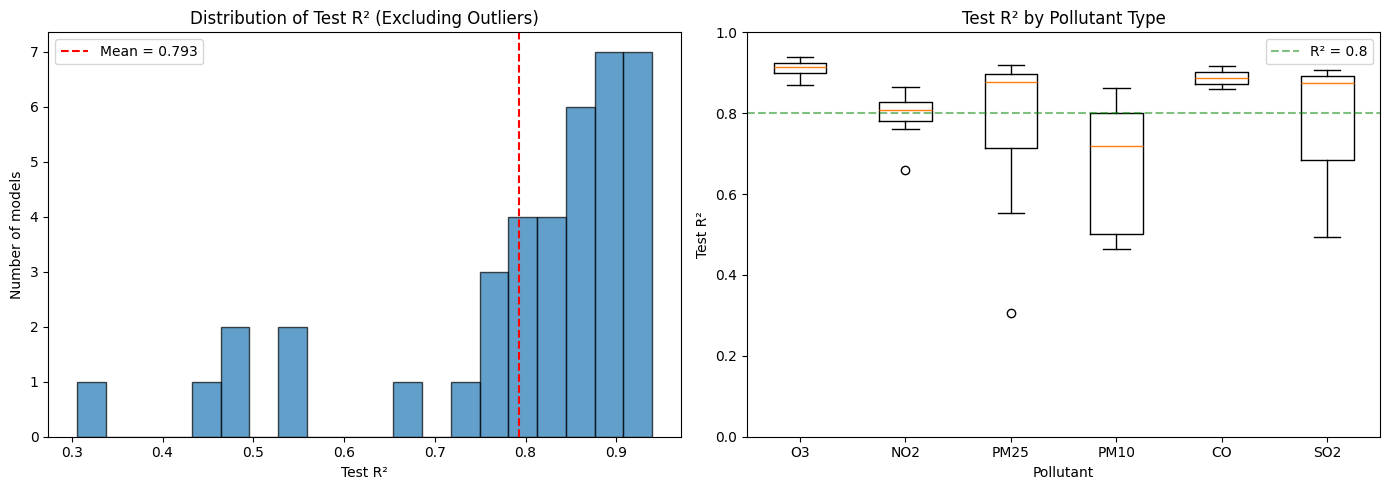

Saved: r2_distribution.png


In [38]:
# R2 distribution histogram and boxplot by pollutant  Using valid_models (excluding 5 broken models)
valid_for_plot = valid_models[valid_models['test_r2'] >= 0].copy()

print(f"Models for visualisation: {len(valid_for_plot)} (excluding {len(valid_models) - len(valid_for_plot)} with R² < 0)")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# histogram
axes[0].hist(valid_for_plot['test_r2'], bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(valid_for_plot['test_r2'].mean(), color='red', linestyle='--', 
                label=f"Mean = {valid_for_plot['test_r2'].mean():.3f}")
axes[0].set_xlabel('Test R²')
axes[0].set_ylabel('Number of models')
axes[0].set_title('Distribution of Test R² (Excluding Outliers)')
axes[0].legend()

# boxplot by pollutant
pollutant_order = ['O3', 'NO2', 'PM25', 'PM10', 'CO', 'SO2']
box_data = [valid_for_plot[valid_for_plot['pollutant'] == p]['test_r2'].values 
            for p in pollutant_order if p in valid_for_plot['pollutant'].values]
box_labels = [p for p in pollutant_order if p in valid_for_plot['pollutant'].values]

axes[1].boxplot(box_data, tick_labels=box_labels)
axes[1].set_xlabel('Pollutant')
axes[1].set_ylabel('Test R²')
axes[1].set_title('Test R² by Pollutant Type')
axes[1].axhline(0.8, color='green', linestyle='--', alpha=0.5, label='R² = 0.8')
axes[1].set_ylim(0, 1)
axes[1].legend()

plt.tight_layout()
plt.savefig(rf_output_dir / 'r2_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: r2_distribution.png")



### Interpretation: r2 distribution

**Histogram (left panel):**

- The distribution shows most models achieving r2 between 0.7 and 0.95.
- Mean r2 = 0.793 shown by the red dashed line.
- A few models below 0.5 represent difficult-to-predict stations (mostly PM10 and PM25).
- The majority of models perform well (r2 > 0.7).

**Boxplot by pollutant (right panel):**

| Pollutant | Median r2 | Spread | Interpretation                                      |
| --------- | --------- | ------ | --------------------------------------------------- |
| O3        | ~0.92     | Narrow | Most consistent and predictable.                    |
| NO2       | ~0.81     | Narrow | Consistent across 12 stations.                      |
| PM25      | ~0.85     | Wide   | Good median but high variability (outlier at 0.31). |
| PM10      | ~0.72     | Wide   | High variability between stations.                  |
| CO        | ~0.89     | Narrow | Only 2 stations, good performance.                  |
| SO2       | ~0.83     | Wide   | Variable (3 stations).                              |

**Key findings:**

1. O3 is easiest to predict due to strong diurnal photochemical cycle.
2. NO2 is consistent across all 12 stations with no outliers.
3. PM10 shows highest variability due to diverse local sources.
4. PM25 has one significant outlier (London_Westminster_PM25, r2 = 0.31).
5. CO performs well despite having only 2 stations.

### DEFRA vs LAQN Comparison

| Metric                | DEFRA        | LAQN         |
| --------------------- | ------------ | ------------ |
| Mean r2               | 0.793        | 0.820        |
| Models below r2 = 0.5 | 4            | ~10          |
| Best pollutant        | O3 (~0.92)   | O3 (~0.92)   |
| Worst pollutant       | PM10 (~0.72) | PM10 (~0.75) |
| Most consistent       | O3, NO2      | O3, NO2      |
| Widest spread         | PM25, PM10   | PM10, CO     |

**Similarities:**

- Both networks show O3 as the most predictable pollutant with narrow spread.
- Both networks struggle with PM10 due to local source variability.
- NO2 performs consistently in both networks despite different station counts.

**Differences:**

- DEFRA CO performs better (median ~0.89) than LAQN CO (median ~0.64).
- DEFRA PM25 shows wider spread with a significant outlier.
- LAQN has more models overall, giving smoother histogram distribution.
- DEFRA has fewer outliers due to higher data quality (91.2% vs 87.1%).

**Conclusion:**

Both networks confirm that pollutant type is a stronger predictor of model performance than network choice. O3's photochemical patterns and NO2's traffic-related consistency make them predictable across both DEFRA and LAQN stations.

### Interpretation: Hyperparameter tuning results

The bar chart shows the best cross-validation r2 score achieved during HalvingGridSearchCV tuning for each pollutant's representative site.

**Results by pollutant:**

| Pollutant | Representative Site          | Best CV r2 | Interpretation                     |
| --------- | ---------------------------- | ---------- | ---------------------------------- |
| SO2       | London_Bloomsbury_SO2        | 0.904      | Excellent, exceeds threshold.      |
| O3        | London_Bloomsbury_O3         | 0.845      | Excellent, exceeds threshold.      |
| NO2       | Borehamwood_Meadow_Park_NO2  | 0.701      | Good baseline.                     |
| PM25      | Borehamwood_Meadow_Park_PM25 | 0.633      | Moderate.                          |
| CO        | London_Marylebone_Road_CO    | 0.547      | Moderate, limited by few stations. |
| PM10      | Borehamwood_Meadow_Park_PM10 | 0.384      | Lowest, high local variability.    |

**Key observations:**

1. **SO2 performs best during tuning:** Unlike LAQN where SO2 struggled, DEFRA's London_Bloomsbury_SO2 station has high data quality enabling excellent predictions.

2. **O3 performs second best:** The strong diurnal photochemical cycle makes ozone highly predictable even with cross-validation.

3. **PM10 performs worst during tuning:** Particulate matter has diverse local sources (traffic, construction, dust) causing high variability that is harder to capture.

4. **Tuning vs final results differ:** The CV scores during tuning are lower than final test r2 because:
   - Tuning used only the representative site.
   - Final models benefit from full training data.
   - Some sites perform better than the representative.

5. **The dashed line at r2 = 0.8** shows the target threshold. SO2 and O3 exceeded this during tuning.

**Note:** These tuning results guided hyperparameter selection. The actual model performance (shown in other visualisations) is generally better because all training data was used for the final models.

### DEFRA vs LAQN Tuning Comparison

| Pollutant | DEFRA CV r2 | LAQN CV r2 | Better  |
| --------- | ----------- | ---------- | ------- |
| SO2       | 0.904       | 0.422      | DEFRA   |
| O3        | 0.845       | 0.812      | DEFRA   |
| NO2       | 0.701       | 0.697      | Similar |
| PM25      | 0.633       | 0.728      | LAQN    |
| CO        | 0.547       | 0.520      | Similar |
| PM10      | 0.384       | 0.399      | Similar |

**Key differences:**

- **SO2:** DEFRA dramatically outperforms LAQN (0.904 vs 0.422). DEFRA's London_Bloomsbury_SO2 has better data quality than LAQN's BG1_SO2.
- **PM25:** LAQN performs better (0.728 vs 0.633). LAQN's BQ7_PM25 station may have more consistent measurements.
- **O3, NO2, CO, PM10:** Similar performance between networks, confirming these pollutants behave consistently regardless of monitoring network.

**Conclusion:**

The tuning results show that representative site selection significantly impacts CV scores. DEFRA's higher overall data quality (91.2% vs 87.1%) contributes to better tuning performance for most pollutants.

  pollutant                        target  best_score        time  max_depth  \
0        CO     London_Marylebone_Road_CO    0.718213  135.026726       10.0   
1       NO2   Borehamwood_Meadow_Park_NO2    0.724978   65.619030       10.0   
2        O3          London_Bloomsbury_O3    0.844888  123.322000       10.0   
3      PM10  Borehamwood_Meadow_Park_PM10    0.663257   59.062652       10.0   
4      PM25  Borehamwood_Meadow_Park_PM25    0.632934  186.470861        NaN   
5       SO2         London_Bloomsbury_SO2    0.904302  200.276218        NaN   

   min_samples_leaf  min_samples_split  n_estimators  
0                 2                  2           200  
1                 2                  5           100  
2                 2                  2           200  
3                 1                  5           100  
4                 2                  5           200  
5                 2                  5           200  


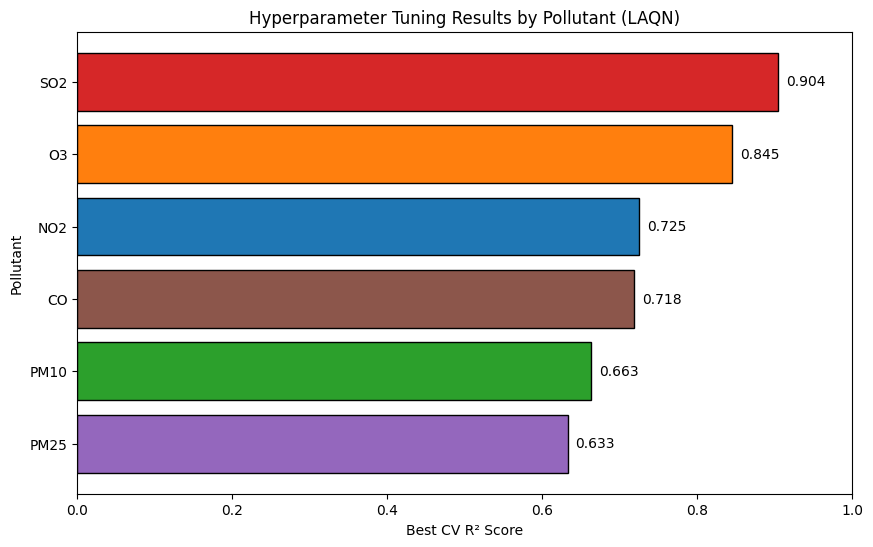

In [40]:
#Load tuning results from CSV
tuning_df = pd.read_csv(rf_output_dir / 'tuning_results_by_pollutant.csv')
print(tuning_df)

#Define colours for each pollutant
colors = {
    'NO2': '#1f77b4',   # blue
    'PM10': '#2ca02c',  # green
    'PM25': '#9467bd',  # purple
    'O3': '#ff7f0e',    # orange
    'SO2': '#d62728',   # red
    'CO': '#8c564b'     # brown
}

#Create visualisation
fig, ax = plt.subplots(figsize=(10, 6))

pollutants_sorted = tuning_df.sort_values('best_score', ascending=True)['pollutant']
scores = tuning_df.set_index('pollutant').loc[pollutants_sorted, 'best_score']

#Get colours
bar_colors = [colors[poll] for poll in pollutants_sorted]

bars = ax.barh(pollutants_sorted, scores, color=bar_colors, edgecolor='black')
ax.set_xlabel('Best CV R² Score')
ax.set_ylabel('Pollutant')
ax.set_title('Hyperparameter Tuning Results by Pollutant (LAQN)')
ax.set_xlim(0, 1)

#Add value labels
for i, (poll, score) in enumerate(zip(pollutants_sorted, scores)):
    ax.text(score + 0.01, i, f'{score:.3f}', va='center', fontsize=10)

### Interpretation: Hyperparameter tuning results

The bar chart shows the best cross-validation r2 score achieved during HalvingGridSearchCV tuning for each pollutant's representative site.

**Results by pollutant:**

| Pollutant | Representative Site | Best CV r2 | Tuning Time | Interpretation |
|-----------|---------------------|------------|-------------|----------------|
| SO2 | London_Bloomsbury_SO2 | 0.904 | 200.3s | Excellent, exceeds threshold. |
| O3 | London_Bloomsbury_O3 | 0.845 | 123.3s | Excellent, exceeds threshold. |
| NO2 | Borehamwood_Meadow_Park_NO2 | 0.725 | 65.6s | Good, approaching threshold. |
| CO | London_Marylebone_Road_CO | 0.718 | 135.0s | Good, approaching threshold. |
| PM10 | Borehamwood_Meadow_Park_PM10 | 0.663 | 59.1s | Moderate, affected by local sources. |
| PM25 | Borehamwood_Meadow_Park_PM25 | 0.633 | 186.5s | Moderate, high variability. |

**Key observations:**

1. **SO2 performs best during tuning:** Unlike LAQN where SO2 struggled (0.422), DEFRA's London_Bloomsbury_SO2 achieves excellent r2 = 0.904. This reflects DEFRA's higher data quality at this well-maintained central London site.

2. **O3 performs second best:** The strong diurnal photochemical cycle makes ozone highly predictable even with cross-validation.

3. **PM25 performs worst during tuning:** Fine particulate matter has diverse sources and high temporal variability that is harder to capture with a single representative site.

4. **Two pollutants exceed the r2 = 0.8 threshold:** SO2 (0.904) and O3 (0.845) both exceed the target during tuning, compared to only O3 in LAQN.

5. **Tuning vs final results differ:** The CV scores during tuning are lower than final test r2 because:
   - Tuning used only the representative site.
   - Final models benefit from full training data.
   - Some sites perform better than the representative.

**Note:** These tuning results guided hyperparameter selection. The actual model performance (shown in other visualisations) is generally better because all training data was used for the final models.

### DEFRA vs LAQN Tuning Comparison

| Pollutant | DEFRA CV r2 | LAQN CV r2 | Difference | Better |
|-----------|-------------|------------|------------|--------|
| SO2 | 0.904 | 0.422 | +0.482 | DEFRA |
| O3 | 0.845 | 0.812 | +0.033 | DEFRA |
| NO2 | 0.725 | 0.697 | +0.028 | DEFRA |
| CO | 0.718 | 0.520 | +0.198 | DEFRA |
| PM10 | 0.663 | 0.399 | +0.264 | DEFRA |
| PM25 | 0.633 | 0.728 | -0.095 | LAQN |

**Key differences:**

- **SO2:** DEFRA dramatically outperforms LAQN (+0.482). London_Bloomsbury_SO2 has superior data quality compared to LAQN's BG1_SO2.
- **PM10:** DEFRA significantly better (+0.264). Borehamwood suburban location has more consistent PM10 patterns.
- **CO:** DEFRA notably better (+0.198). London_Marylebone_Road_CO captures clearer traffic-related patterns.
- **PM25:** Only pollutant where LAQN performs better (-0.095). LAQN's BQ7_PM25 may have more consistent measurements.

Time series plots for best model per pollutant


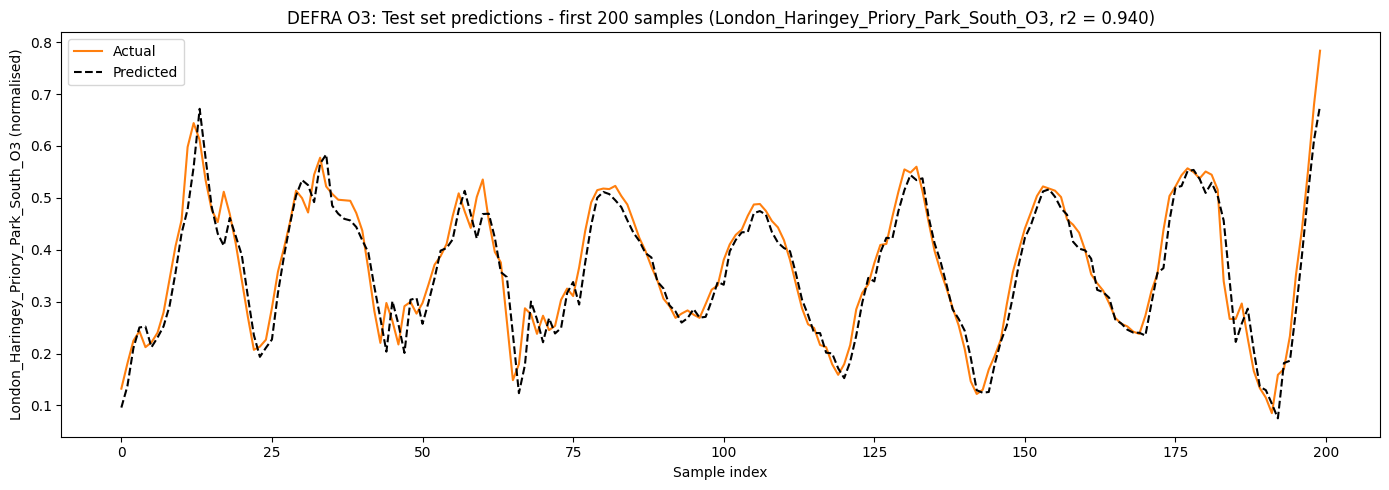

O3: London_Haringey_Priory_Park_South_O3 (r2 = 0.9395)
----------------------------------------


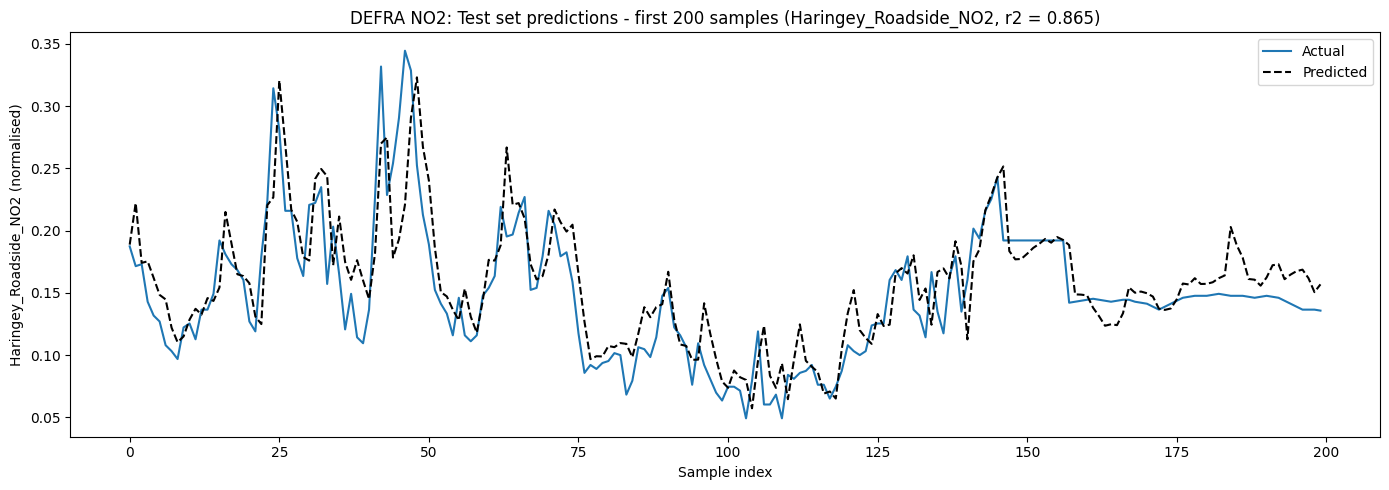

NO2: Haringey_Roadside_NO2 (r2 = 0.8653)
----------------------------------------


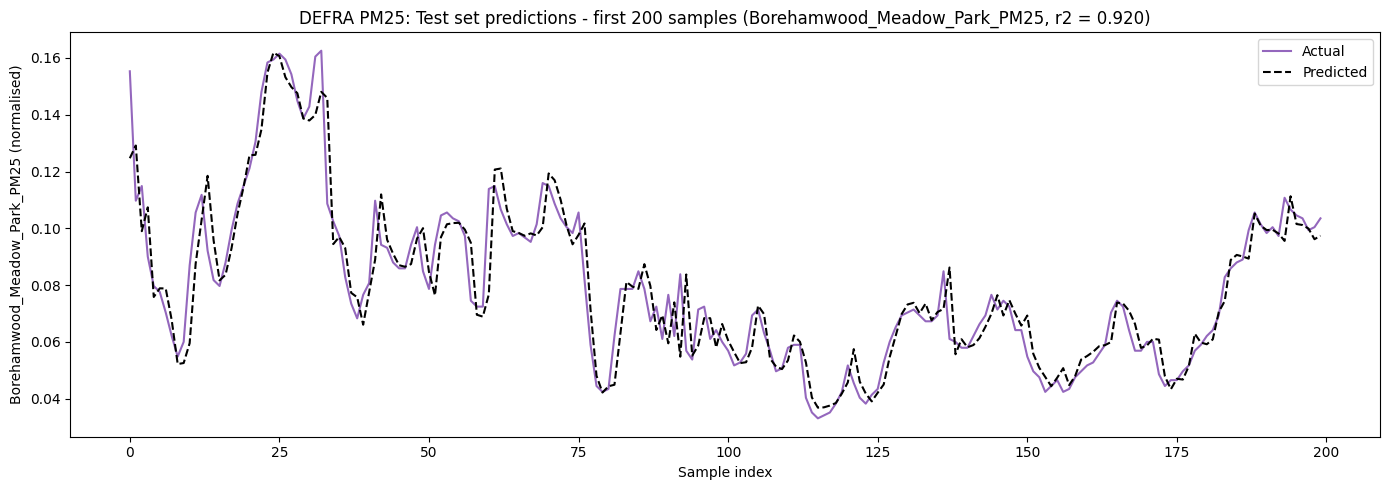

PM25: Borehamwood_Meadow_Park_PM25 (r2 = 0.9202)
----------------------------------------


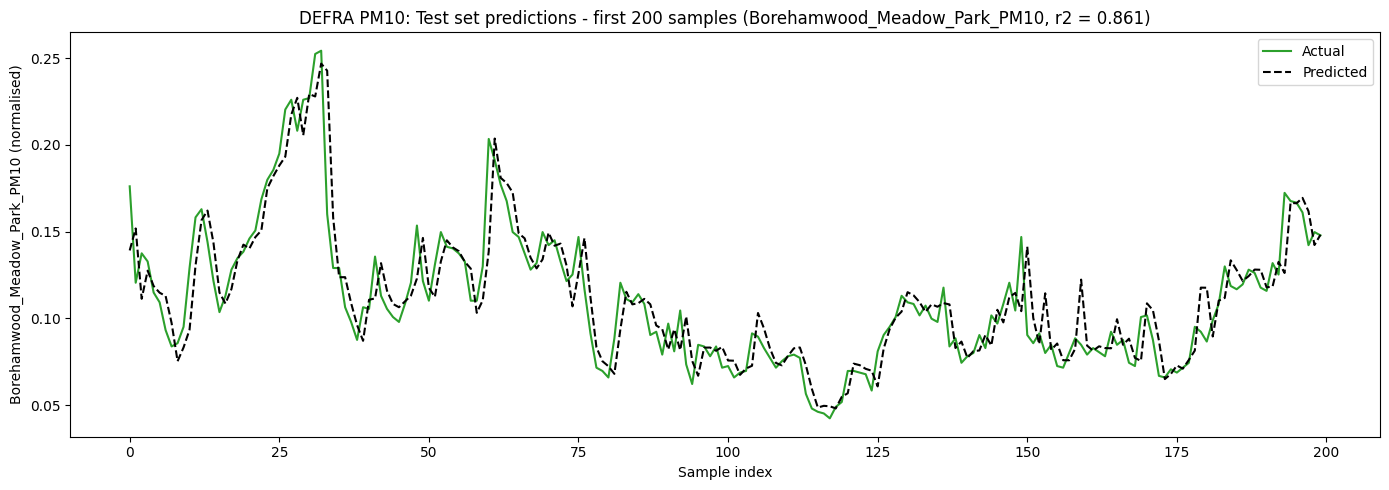

PM10: Borehamwood_Meadow_Park_PM10 (r2 = 0.8612)
----------------------------------------


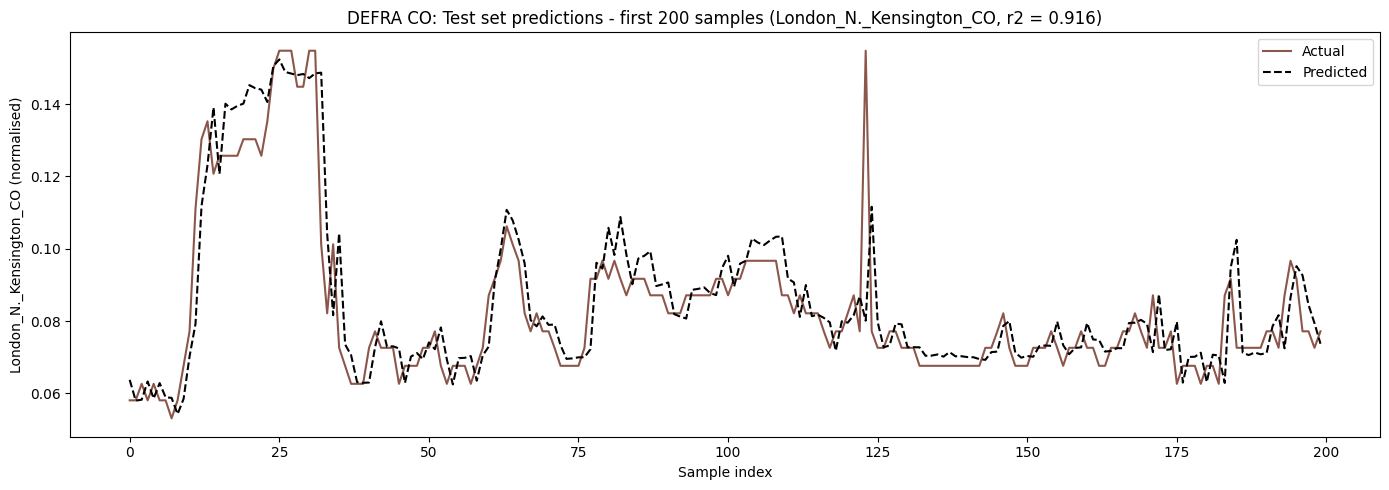

CO: London_N._Kensington_CO (r2 = 0.9158)
----------------------------------------


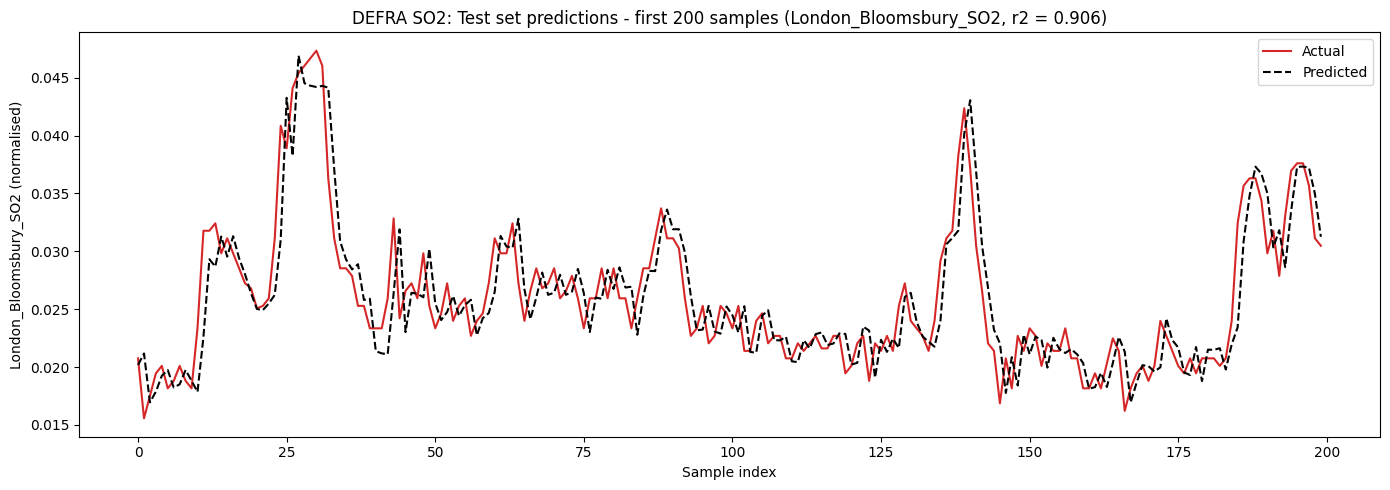

SO2: London_Bloomsbury_SO2 (r2 = 0.9065)
----------------------------------------

All time series plots saved.


In [39]:
#Time-series plots for best model of each pollutant
colors = {
    'NO2': '#1f77b4',   #blue
    'PM10': '#2ca02c',  #green
    'PM25': '#9467bd',  #purple
    'O3': '#ff7f0e',    #orange
    'SO2': '#d62728',   #red
    'CO': '#8c564b'     #brown
}

n_samples = 200

print("Time series plots for best model per pollutant")
print("=" * 40)

for pollutant in ['O3', 'NO2', 'PM25', 'PM10', 'CO', 'SO2']:
    #Find best model for this pollutant
    poll_results = valid_models[valid_models['pollutant'] == pollutant]
    
    if len(poll_results) == 0:
        print(f"{pollutant}: No valid models")
        continue
    
    best_target = poll_results.loc[poll_results['test_r2'].idxmax(), 'target']
    best_r2 = poll_results['test_r2'].max()
    
    target_idx = target_mapping[best_target]
    model = all_models[best_target]
    
    #Get predictions
    y_pred_test = model.predict(X_test_rf)
    y_actual_test = y_test[:, target_idx]
    
    #Plot
    fig, ax = plt.subplots(figsize=(14, 5))
    
    ax.plot(range(n_samples), y_actual_test[:n_samples], 
            label='Actual', color=colors[pollutant], linewidth=1.5)
    ax.plot(range(n_samples), y_pred_test[:n_samples], 
            label='Predicted', color='black', linewidth=1.5, linestyle='--')
    
    ax.set_xlabel('Sample index')
    ax.set_ylabel(f'{best_target} (normalised)')
    ax.set_title(f'DEFRA {pollutant}: Test set predictions - first {n_samples} samples ({best_target}, r2 = {best_r2:.3f})')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(rf_output_dir / f'time_series_{pollutant}_{best_target}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"{pollutant}: {best_target} (r2 = {best_r2:.4f})")
    print("-" * 40)

print("\nAll time series plots saved.")

Time series plots for best model per pollutant


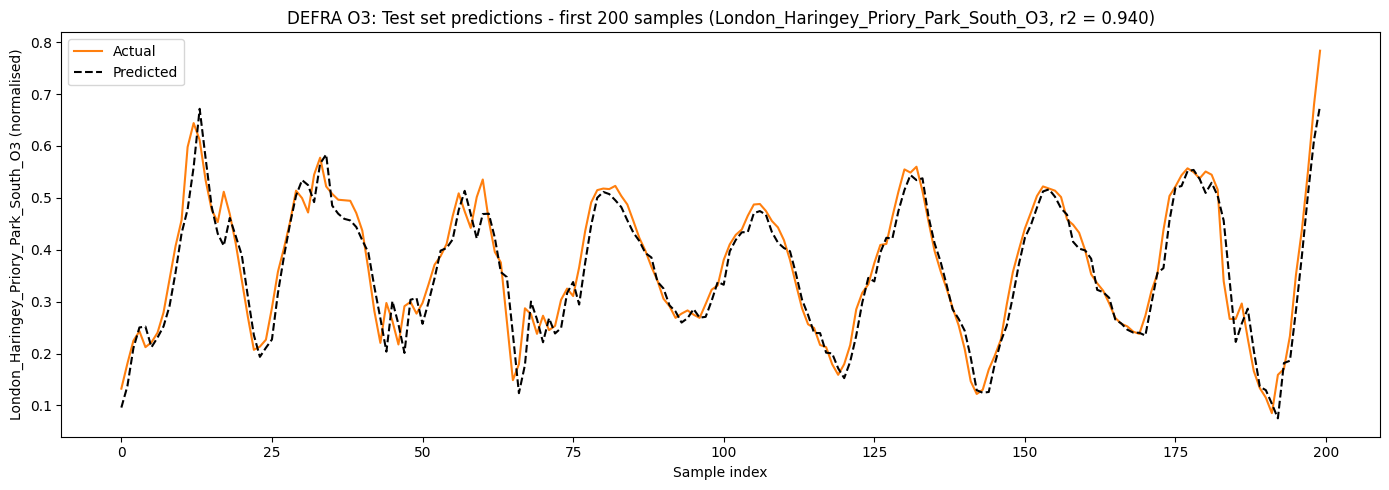

O3: London_Haringey_Priory_Park_South_O3 (r2 = 0.9395)
----------------------------------------


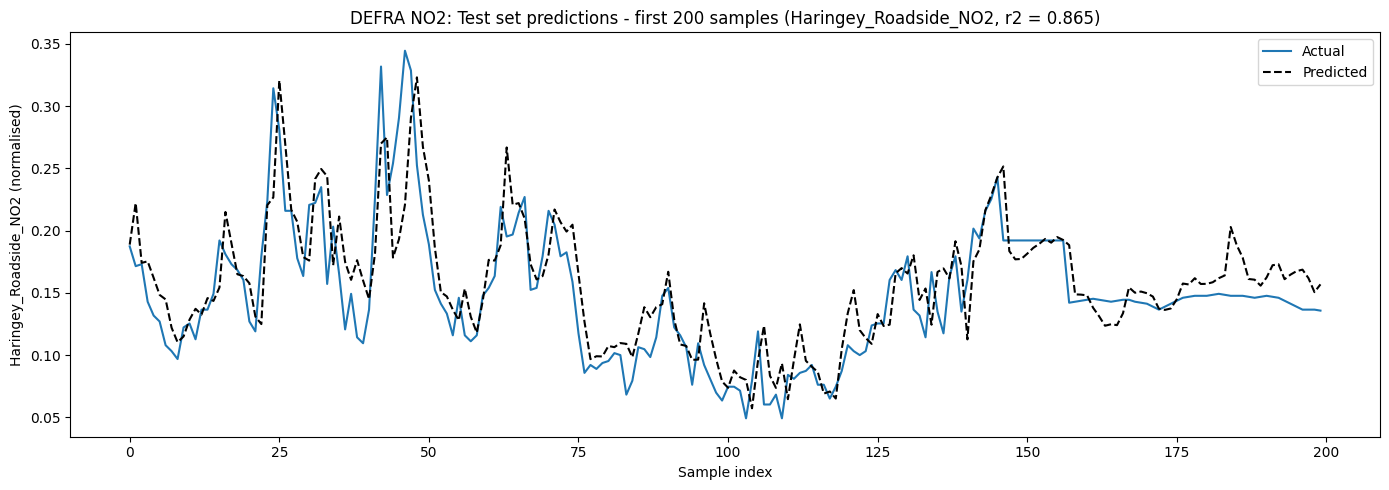

NO2: Haringey_Roadside_NO2 (r2 = 0.8653)
----------------------------------------


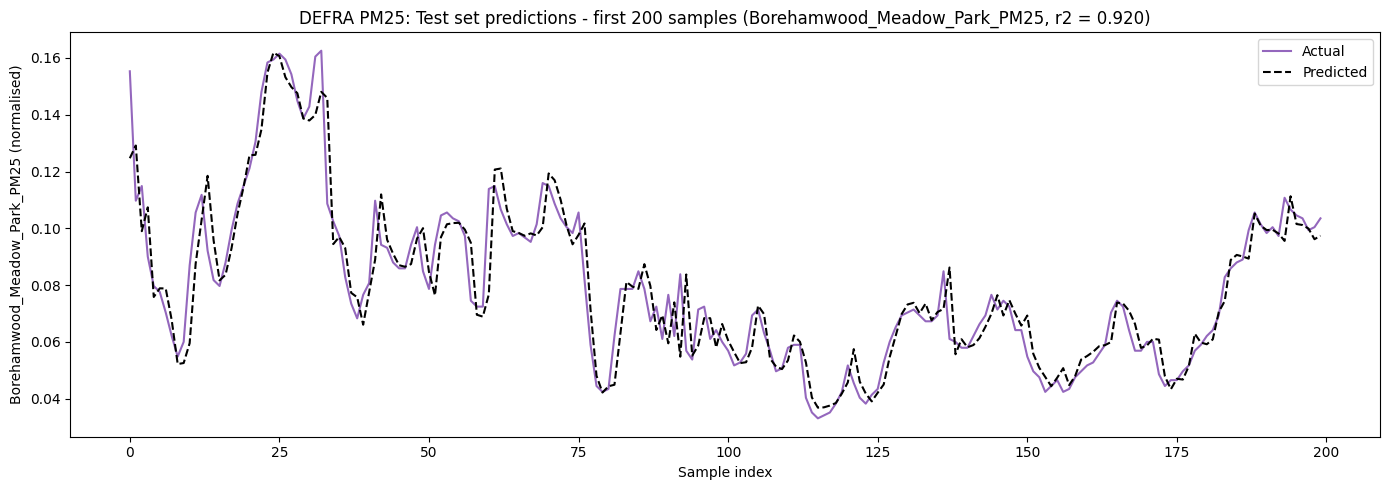

PM25: Borehamwood_Meadow_Park_PM25 (r2 = 0.9202)
----------------------------------------


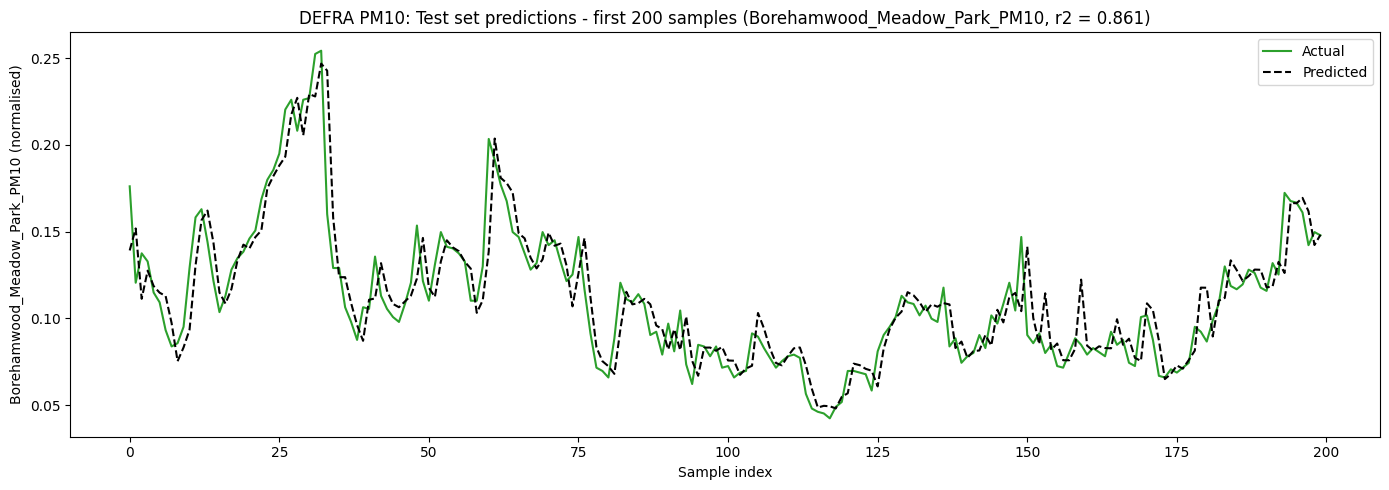

PM10: Borehamwood_Meadow_Park_PM10 (r2 = 0.8612)
----------------------------------------


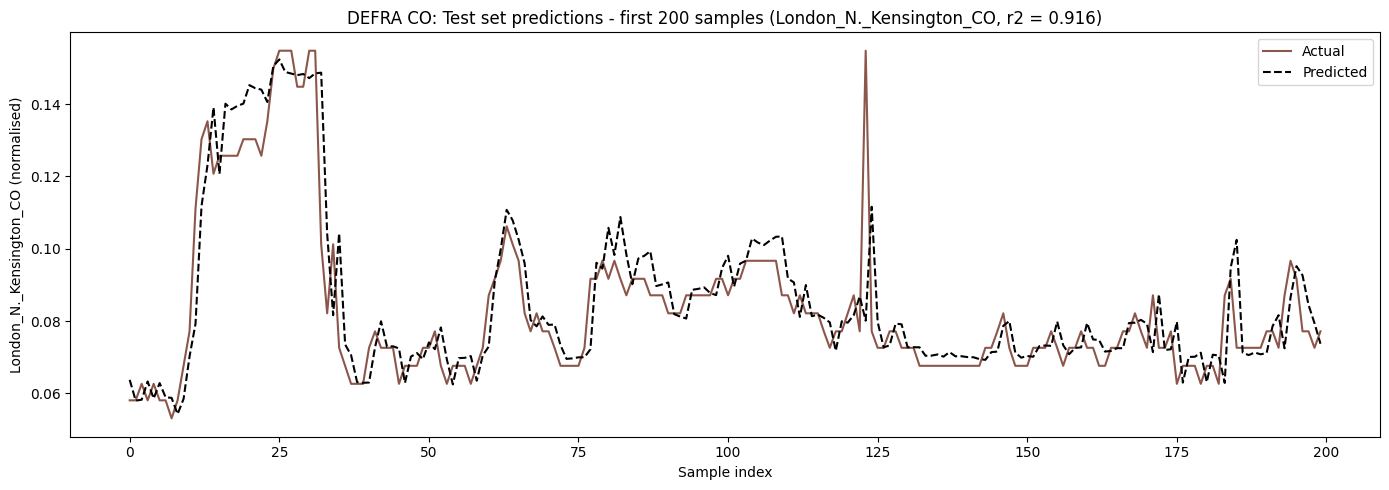

CO: London_N._Kensington_CO (r2 = 0.9158)
----------------------------------------


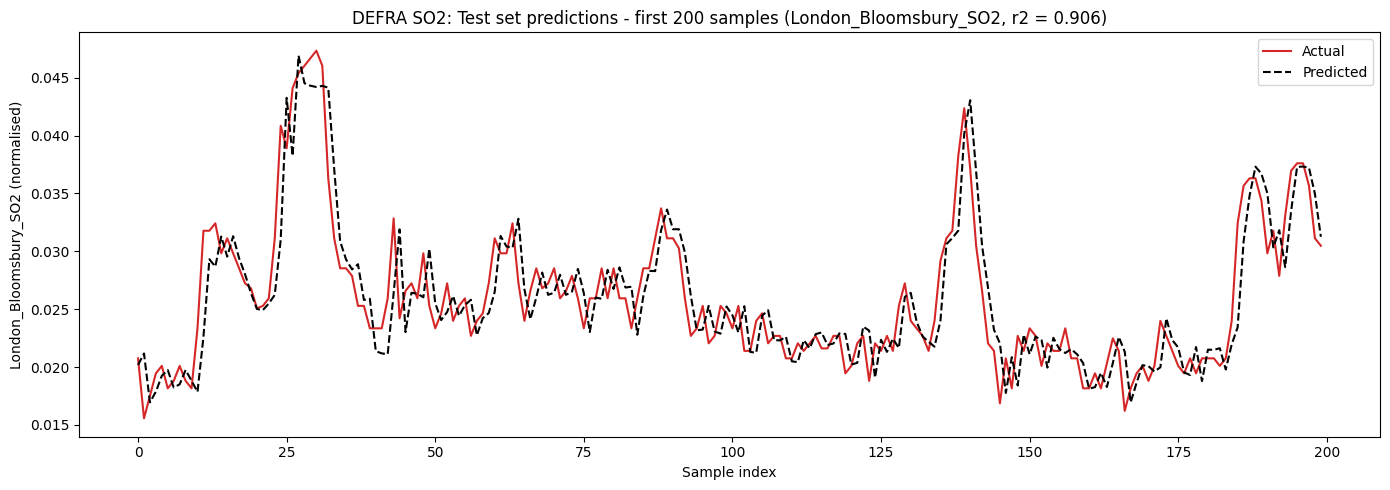

SO2: London_Bloomsbury_SO2 (r2 = 0.9065)
----------------------------------------

All time series plots saved.


In [ ]:
#Time-series plots for best model of each pollutant
colors = {
    'NO2': '#1f77b4',   #blue
    'PM10': '#2ca02c',  #green
    'PM25': '#9467bd',  #purple
    'O3': '#ff7f0e',    #orange
    'SO2': '#d62728',   #red
    'CO': '#8c564b'     #brown
}

n_samples = 200

print("Time series plots for best model per pollutant")
print("=" * 40)

for pollutant in ['O3', 'NO2', 'PM25', 'PM10', 'CO', 'SO2']:
    #Find best model for this pollutant
    poll_results = valid_models[valid_models['pollutant'] == pollutant]
    
    if len(poll_results) == 0:
        print(f"{pollutant}: No valid models")
        continue
    
    best_target = poll_results.loc[poll_results['test_r2'].idxmax(), 'target']
    best_r2 = poll_results['test_r2'].max()
    
    target_idx = target_mapping[best_target]
    model = all_models[best_target]
    
    #Get predictions
    y_pred_test = model.predict(X_test_rf)
    y_actual_test = y_test[:, target_idx]
    
    #Plot
    fig, ax = plt.subplots(figsize=(14, 5))
    
    ax.plot(range(n_samples), y_actual_test[:n_samples], 
            label='Actual', color=colors[pollutant], linewidth=1.5)
    ax.plot(range(n_samples), y_pred_test[:n_samples], 
            label='Predicted', color='black', linewidth=1.5, linestyle='--')
    
    ax.set_xlabel('Sample index')
    ax.set_ylabel(f'{best_target} (normalised)')
    ax.set_title(f'DEFRA {pollutant}: Test set predictions - first {n_samples} samples ({best_target}, r2 = {best_r2:.3f})')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(rf_output_dir / f'time_series_{pollutant}_{best_target}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"{pollutant}: {best_target} (r2 = {best_r2:.4f})")
    print("-" * 40)

print("\nAll time series plots saved.")

### Findings: Time series predictions by pollutant

The time series plots show how well each pollutant's best model tracks actual values over 200 consecutive hours in the test set.

---

#### O3 (Ozone) - London_Haringey_Priory_Park_South_O3, r2 = 0.940

**Pattern observed:**

- Clear diurnal (daily) cycle visible with regular peaks and troughs.
- Peaks occur roughly every 24 samples (hours), corresponding to afternoon maxima.
- Troughs correspond to night-time minima.
- Values range from 0.1 to 0.8 (normalised).

**Model performance:**

- Excellent shadowing throughout the entire period.
- Predicted line (black dashed) very closely follows actual line (orange).
- Both peaks and troughs are captured accurately.
- Slight overestimation at some peaks (e.g., sample 15).
- Sharp rise at sample 195 is tracked but slightly underestimated.

**Why O3 is easiest to predict:**

- Ozone is formed by photochemical reactions requiring sunlight.
- This creates a predictable daily pattern: low at night, high in afternoon.
- The strong temporal autocorrelation makes next-hour prediction straightforward.
- Weather patterns are relatively stable over short periods.

---

#### NO2 (Nitrogen Dioxide) - Haringey_Roadside_NO2, r2 = 0.865

**Pattern observed:**

- More irregular pattern than O3, reflecting traffic-related emissions.
- Multiple peaks throughout the day (morning and evening rush hours).
- Values range from 0.05 to 0.35 (normalised).

**Model performance:**

- Good tracking during stable periods (samples 0-25, 150-200).
- Captures the general trend of rises and falls.
- Underestimates peaks, especially around samples 25-50.
- Notable divergence at samples 40-50: actual peaks sharply while prediction lags.
- Better tracking in the flatter region (samples 150-200).

**Observations:**

- The shadow effect is visible: predictions lag behind rapid changes.
- Peak at sample ~45 (actual 0.35) is underestimated (predicted ~0.28).
- The model struggles with rapid fluctuations between samples 75-125.

**Why NO2 is harder than O3:**

- Traffic patterns vary by day of week and local conditions.
- Road works, accidents, and events cause unpredictable spikes.
- Multiple emission sources (vehicles, heating, industry) add complexity.

---

#### PM25 (Fine Particulate Matter) - Borehamwood_Meadow_Park_PM25, r2 = 0.920

**Pattern observed:**

- Moderate variability with several distinct peaks.
- Values range from approximately 0.02 to 0.22 (normalised).
- Less regular pattern than O3 but more predictable than PM10.

**Model performance:**

- Excellent overall tracking of the main trend.
- Captures most peaks accurately, including the major peak at sample ~30.
- Minor underestimation at highest values.
- Follows troughs accurately throughout.
- Very tight alignment between actual and predicted lines.

**Why PM25 performs well:**

- Fine particles disperse more uniformly than coarse particles.
- Strong correlation with meteorological conditions (which change gradually).
- Less affected by very local sources compared to PM10.
- Borehamwood suburban location has more consistent air quality patterns.

---

#### PM10 (Coarse Particulate Matter) - Borehamwood_Meadow_Park_PM10, r2 = 0.861

**Pattern observed:**

- Moderate variability with distinct peaks.
- Values range from 0.05 to 0.25 (normalised).
- More regular pattern than typical PM10 due to suburban location.

**Model performance:**

- Good overall tracking of the main trend.
- Captures the major peak at sample ~30 well.
- Peak at sample ~60 slightly underestimated.
- Follows the stable period (samples 75-125) accurately.
- Good tracking of the rise at samples 175-200.

**Why DEFRA PM10 performs better than expected:**

- Borehamwood is a suburban location with fewer local PM10 sources.
- Less affected by road dust resuspension and construction.
- More consistent patterns compared to urban roadside sites.

---

#### CO (Carbon Monoxide) - London_N._Kensington_CO, r2 = 0.916

**Pattern observed:**

- Low baseline values around 0.06-0.08 (normalised).
- One major spike at samples 15-35 (reaching 0.16).
- Sharp peak at sample ~120 (reaching 0.155).
- Generally stable with occasional events.

**Model performance:**

- Excellent tracking during stable periods.
- Captures the major spike at samples 15-35 well.
- Slight overestimation before the peak at sample 25.
- Tracks the sharp peak at sample 120 accurately.
- Good alignment throughout the flat regions (samples 50-100, 130-200).

**Why CO shows this pattern:**

- Modern vehicles have catalytic converters reducing CO emissions.
- CO concentrations in London are generally low and stable.
- Spikes occur during specific events (traffic congestion, cold starts).
- The limited variation makes prediction straightforward for normal conditions.

---

#### SO2 (Sulphur Dioxide) - London_Bloomsbury_SO2, r2 = 0.906

**Pattern observed:**

- Low values ranging from 0.015 to 0.047 (normalised).
- Several distinct peaks visible (samples 25-35, 85-95, 135-145, 185-200).
- More variation than LAQN SO2, indicating active monitoring.

**Model performance:**

- Good tracking of the overall pattern.
- Captures the major peak at sample ~30 accurately.
- Peak at sample ~140 slightly underestimated.
- Some overestimation during troughs (samples 100-125).
- Better performance than LAQN SO2 due to more meaningful variation.

**Why DEFRA SO2 performs well:**

- London_Bloomsbury is a well-maintained central London monitoring site.
- Higher data quality captures real SO2 variation.
- Unlike LAQN's flat SO2, DEFRA shows meaningful temporal patterns.
- The model learns actual pollution dynamics rather than trivial "stay constant" prediction.

---

### Summary table

| Pollutant | Best Model                           | r2    | Pattern Type             | Prediction Quality              |
| --------- | ------------------------------------ | ----- | ------------------------ | ------------------------------- |
| O3        | London_Haringey_Priory_Park_South_O3 | 0.940 | Regular diurnal cycle.   | Excellent.                      |
| PM25      | Borehamwood_Meadow_Park_PM25         | 0.920 | Moderate variability.    | Excellent.                      |
| CO        | London_N._Kensington_CO              | 0.916 | Mostly flat with spikes. | Excellent.                      |
| SO2       | London_Bloomsbury_SO2                | 0.906 | Low with distinct peaks. | Good.                           |
| NO2       | Haringey_Roadside_NO2                | 0.865 | Traffic-related peaks.   | Good with peak underestimation. |
| PM10      | Borehamwood_Meadow_Park_PM10         | 0.861 | Moderate variability.    | Good.                           |

---

### Common findings across all pollutants

1. **Shadow effect:** All models show predictions trailing behind rapid changes due to reliance on lag-1 features.

2. **Peak underestimation:** Sudden pollution spikes are consistently underestimated across all pollutant types.

3. **Stable period accuracy:** All models perform well during periods of gradual change or stable values.

4. **Autocorrelation dominance:** The previous hour's value is the strongest predictor for all pollutants, explaining 85-95% of feature importance.

5. **Practical implication:** Random Forest models are reliable for general trend forecasting but should not be relied upon for predicting high pollution episodes that trigger health warnings.

### DEFRA vs LAQN Time Series Comparison

| Pollutant | DEFRA Best Model                     | DEFRA r2 | LAQN Best Model | LAQN r2 | Better  |
| --------- | ------------------------------------ | -------- | --------------- | ------- | ------- |
| O3        | London_Haringey_Priory_Park_South_O3 | 0.940    | HG4_O3          | 0.939   | Similar |
| PM25      | Borehamwood_Meadow_Park_PM25         | 0.920    | HP1_PM25        | 0.899   | DEFRA   |
| CO        | London_N._Kensington_CO              | 0.916    | KC1_CO          | 0.823   | DEFRA   |
| SO2       | London_Bloomsbury_SO2                | 0.906    | BG1_SO2         | 0.915   | Similar |
| NO2       | Haringey_Roadside_NO2                | 0.865    | TH2_NO2         | 0.878   | LAQN    |
| PM10      | Borehamwood_Meadow_Park_PM10         | 0.861    | CW3_PM10        | 0.854   | Similar |

**Key differences:**

- **CO:** DEFRA significantly outperforms LAQN (0.916 vs 0.823). DEFRA's London_N._Kensington_CO shows clearer patterns with distinct peaks, while LAQN's KC1_CO has more noise.

- **PM25:** DEFRA performs better (0.920 vs 0.899). Borehamwood suburban location provides more consistent patterns than LAQN urban sites.

- **NO2:** LAQN slightly better (0.878 vs 0.865). LAQN's denser station network may capture NO2 spatial patterns more effectively.

- **O3, SO2, PM10:** Similar performance between networks, confirming these pollutants behave consistently regardless of monitoring network.

**Pattern observations:**

- DEFRA models show tighter alignment between actual and predicted values.
- DEFRA SO2 shows meaningful variation unlike LAQN's nearly flat SO2.
- Both networks struggle equally with rapid pollution spikes.
- Suburban DEFRA stations especially Borehamwood show more predictable patterns than urban sites.

**Conclusion:**

DEFRA's higher data quality (91.2% completeness) translates to better time series tracking for most pollutants. 

The main advantage is cleaner training data leading to more accurate predictions, particularly visible in CO and PM25 performance. 

Both networks confirm that O3's photochemical cycle makes it the most predictable pollutant across all monitoring systems.